In [2]:
import re
import glob
import pywt

import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('darkgrid')
color = sns.color_palette()

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV


import xgboost as xgb

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

### Concatenate all the files

In [3]:
# get path to all files
path = 'data/spectra/simulated_data/'

files = sorted(glob.glob(path + 'model_parameters_data*.txt'), key=lambda x: int(re.search(r'\d+', x).group()))

# get the first 500 files 
files = files[:5000]

output_path = 'data/params/'
write_data = open(output_path + 'model_parameters_data_all_5K.txt', 'w')

# read in all files
for file in files:
    with open(file, 'r') as f:
        # skip the first 10 lines in each file
        for i in range(10):
            f.readline()
        # read in the data from each file
        data = f.readlines()
        # write the data to the output file in the same order as the files
        for i in range(len(data)):
            write_data.write(data[i])

write_data.close()  

In [4]:
# get the params data
df_param = pd.DataFrame()
for file in files:
    # get the parameters used
    df_param = df_param.append(pd.read_csv(file, skiprows=1, nrows=6, header=None, sep=' ', names=['A', 'B', 'C', 'D']))
    # save the dataframe to a csv file
df_param.to_csv(output_path + 'model_parameters_data_5K.csv', index=False)

#### Load the files 

In [5]:
df_data = pd.read_csv(output_path + 'model_parameters_data_all_5K.txt', sep=' ', header=None) # all data dataframe
df_data.head()

0    1
0  238.60000  0.0
1  238.60001  0.0
2  238.60002  0.0
3  238.60003  0.0
4  238.60004  0.0

In [6]:
df_data.shape

(290000000, 2)

In [7]:
df_param = pd.read_csv(output_path + 'model_parameters_data_5K.csv')
df_param.head()

A  B             C     D
0  tcmb  =  2.730000e+00     K
1  ntot  =  9.035557e+18  cm-2
2   tex  =  1.313036e+02     K
3  fwhm  =  2.933735e+00  km/s
4  vlsr  =  1.702059e+01  km/s

In [8]:
# drop the second and fourth column
df_param.drop(['B', 'D'], axis=1, inplace=True)

In [9]:
# transform the data to the right dataframe
df_param = df_param.assign(g = df_param.groupby('A').cumcount()).pivot(index='g', columns='A', values='C')

In [10]:
df_param.head(10)

A       fwhm          ntot      size  tcmb         tex       vlsr
g                                                                
0   2.933735  9.035557e+18  1.332560  2.73  131.303629  17.020590
1   6.144747  1.329373e+18  0.388745  2.73   68.564338  13.937171
2   5.936799  7.038781e+17  2.270334  2.73  306.109908  32.571172
3  10.075154  7.898081e+16  0.465409  2.73   53.727434 -12.442107
4   6.654279  6.687129e+16  0.464912  2.73  374.698519 -27.878288
5   3.197202  1.579432e+16  0.417047  2.73  299.269394  -4.419249
6   6.269222  1.975123e+18  1.419747  2.73  154.224519 -12.908657
7   5.466756  2.304166e+16  1.044501  2.73  373.507560  18.794082
8   4.527537  1.831597e+17  0.635137  2.73   12.217461 -39.213550
9   5.542682  1.333910e+16  0.926891  2.73   90.838083  18.021617

In [11]:
df_param.columns

Index(['fwhm', 'ntot', 'size', 'tcmb', 'tex', 'vlsr'], dtype='object', name='A')

In [12]:
columns = ['Frequency', 'Intensity']
df_data.columns = columns
df_data.shape

(290000000, 2)

In [13]:
df_data.head()

Frequency  Intensity
0  238.60000        0.0
1  238.60001        0.0
2  238.60002        0.0
3  238.60003        0.0
4  238.60004        0.0

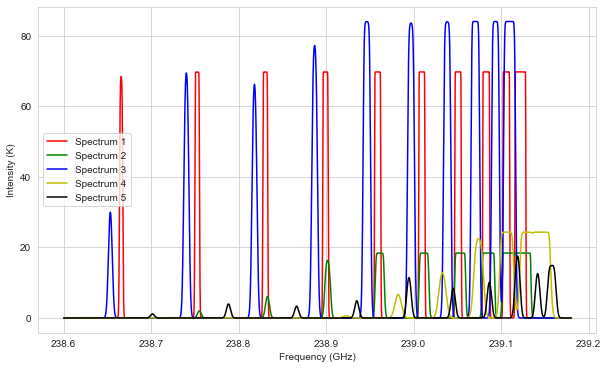

In [14]:
freq_sig = np.array(np.array_split(df_data['Frequency'], len(files)))
signal = np.array(np.array_split(df_data['Intensity'], len(files)))

# plot the signal in one plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
plt.plot(freq_sig[0],  signal[0], color='r', label='Spectrum 1')
plt.plot(freq_sig[1], signal[1], color='g', label='Spectrum 2')
plt.plot(freq_sig[2], signal[2], color='b', label='Spectrum 3')
plt.plot(freq_sig[3], signal[3], color='y', label='Spectrum 4')
plt.plot(freq_sig[4], signal[4], color='k', label='Spectrum 5')
plt.xlabel("Frequency (GHz)")
plt.ylabel("Intensity (K)")
plt.legend()
plt.show()

In [15]:
len(freq_sig)
freq_sig.shape

(5000, 58000)

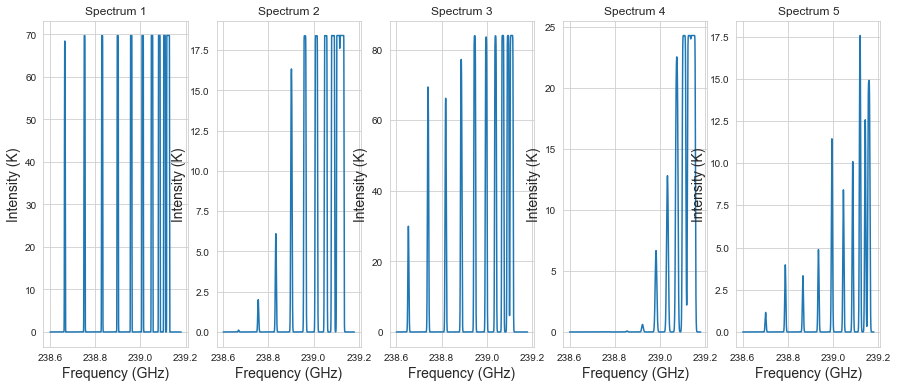

In [16]:
# plot the data in separate plots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 6))
sns.set_style("whitegrid")
for i, ax in enumerate(axes.ravel(), start=1):
    ax.plot(freq_sig[i-1], signal[i-1], label='Spectrum {}'.format(i))
    ax.set_xlabel("Frequency (GHz)", fontdict={'fontsize': 14})
    ax.set_ylabel("Intensity (K)", fontdict={'fontsize': 14})
    ax.set_title("Spectrum {}".format(i))
    
# plt.savefig('../spectra/simulated_data/spectrum_plots.png')

In [17]:
# print(pywt.wavelist())

### Feature Extraction - Wavelet Decomposition

In [18]:
#create a  feature vector array for each spectrum 
feature_vector = np.zeros((len(signal), int(df_data.shape[0]/len(files))))
detail_coeffs = np.zeros((len(signal), 907))
approx_coeffs = np.zeros((len(signal), 907))
level = 6
wname = 'db35'
def decompose_signal_dwt(_signal, wavelet=wname, mode='per', level=level):
    """
    Performs wavelet denoising on the given signal.
    """
    # loop throuh all the spectra 
    for spectra_index in range(len(_signal)):
        # max_level = pywt.dwt_max_level(len(_signal[spectra_index]), wavelet)
        coeffs = pywt.wavedec(_signal[spectra_index], wavelet=wavelet, mode=mode, level=level)
        coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
        detail_coeffs[spectra_index, :] = coeff_arr[coeff_slices[1]['d']] # 4th level detail coeffs 
        # get the approximation coeffs
        approx_coeffs[spectra_index, :] = coeffs[0] # 4th level approximation coeffs
        
        reconstructed_signal = pywt.waverec(coeffs, wavelet=wavelet, mode=mode)
        feature_vector[spectra_index, :] = coeff_arr[:int(df_data.shape[0]/len(files))]
        # add the coeff_arr to the dataframe for each spectra
        # df_data['fv_dwt_{}'.format(wavelet)] = pd.Series(feature_vector.reshape(1, -1)[0], index=df_data.index) #TODO: find a way to optimize (or comment it out)
        
    return coeff_arr, coeff_slices

In [19]:
feature_vector.shape

(5000, 58000)

In [20]:
coeff_arr, coeff_slices = decompose_signal_dwt(signal)
df_data

Frequency  Intensity
0          238.60000        0.0
1          238.60001        0.0
2          238.60002        0.0
3          238.60003        0.0
4          238.60004        0.0
...              ...        ...
289999995  239.17995        0.0
289999996  239.17996        0.0
289999997  239.17997        0.0
289999998  239.17998        0.0
289999999  239.17999        0.0

[290000000 rows x 2 columns]

In [21]:
detail_coeffs.shape
detail_coeffs

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 4.82662774e-18,  1.58902161e-18, -3.80478960e-19, ...,
        -1.15242629e-16, -2.17657787e-17, -1.66907711e-17],
       [ 4.66245479e-11, -1.00777537e-11, -3.44064609e-13, ...,
         5.05895219e-09, -6.38109728e-09,  6.65115257e-10],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

## Wavelet Decomposition Plots

In [22]:
def decomposed_dwt_detail_coeffs_plots(_signal, wavelet=wname, level=level):
    """
    Plots of the detail coeffs of the signal.
    """
    # plot the reconstructed signal and the original signal in one plot
    for spectra_index in range(len(_signal)):                     
        # compute the maximum useful level of decomposition for each wavelet                        
        # max_level = pywt.dwt_max_level(len(_signal[spectra_index]), wavelet)
        fig, axes = plt.subplots(nrows=1, ncols=level, dpi=400, sharey='none', sharex='all', figsize=(18, 5))
        sns.set_style("whitegrid")
        for i, ax in enumerate(axes.ravel(), start=1):
            ax.plot(coeff_arr[coeff_slices[i]['d']], label='Level {}'.format(i))
            ax.set_xlabel("Frequency (GHz)", fontdict={'fontsize': 14})
            ax.set_ylabel("Intensity (K)", fontdict={'fontsize': 14})
            ax.set_title("Spectrum {} detail coeffiecients at level {} for {} ".format(spectra_index+1, i, wavelet)) 
            
        plt.show()

In [23]:
# decomposed_dwt_detail_coeffs_plots(signal) 

In [24]:
# TODO: find a way to plot the detail coefficients of the signal
def decomposed_dwt_approx_coeffs_plots(_signal, wavelet=wname, level=level):
    
    for spectra_index in range(len(_signal)):
        fig, axes = plt.subplots(nrows=1, ncols=level, figsize=(10, 6))
        sns.set_style("whitegrid")
        for i, ax in enumerate(axes.ravel(), start=1):
            ax.plot(coeff_arr[coeff_slices[1]['d']])
            ax.set_title("Spectrum {} approximation coeffiecients at level {} for {} ".format(spectra_index+1, i,  wavelet))
            
        plt.show()

In [25]:
# decomposed_dwt_approx_coeffs_plots(signal)

### Get Features and Labels

In [26]:
# fv = np.zeros((len(signal), int(df.shape[0]/len(files))))
# for spectra_index in range(len(signal)):
#     # get the level 3 detail coefficients
#     detail_coeffs = coeff_arr[coeff_slices[3]['d']]

# fv  = detail_coeffs
# labels =dff

In [27]:
# len(signal)

approx_coeffs.shape

(5000, 907)

 #### Have a glimpse look at any of the signal and its generated detail and approximation coefficients 

In [28]:

# for spectra_index in range(len(signal)):                     
#         # compute the maximum useful level of decomposition for each wavelet                        
#         # max_level = pywt.dwt_max_level(len(_signal[spectra_index]), wavelet)
#         fig, axes = plt.subplots(nrows=1, ncols=10, sharey='none', sharex='all', figsize=(20, 7))
#         sns.set_style("whitegrid")
#         for i, ax in enumerate(axes.ravel(), start=1):
#             ax.plot(signal[spectra_index], label='Spectrum {}'.format(spectra_index))
#             # ax.set_xlabel("Frequency (GHz)", fontdict={'fontsize': 14})
#             # ax.set_ylabel("Intensity (K)", fontdict={'fontsize': 14})
#             # ax.set_title("Spectrum {} detail coeffiecients at level {} for {} ".format(spectra_index+1, i, wavelet)) 

#     # ax[0,1].plot(signal[spectra_index], label='original')
#     # ax[1,1].plot(approx_coeffs[spectra_index], label='spectrum {} approx coeff'.format(spectra_index+1))
#     # ax[2,1].plot(detail_coeffs[spectra_index], label='spectrum {} detail coeff'.format(spectra_index+1))
# plt.legend()
# plt.show()

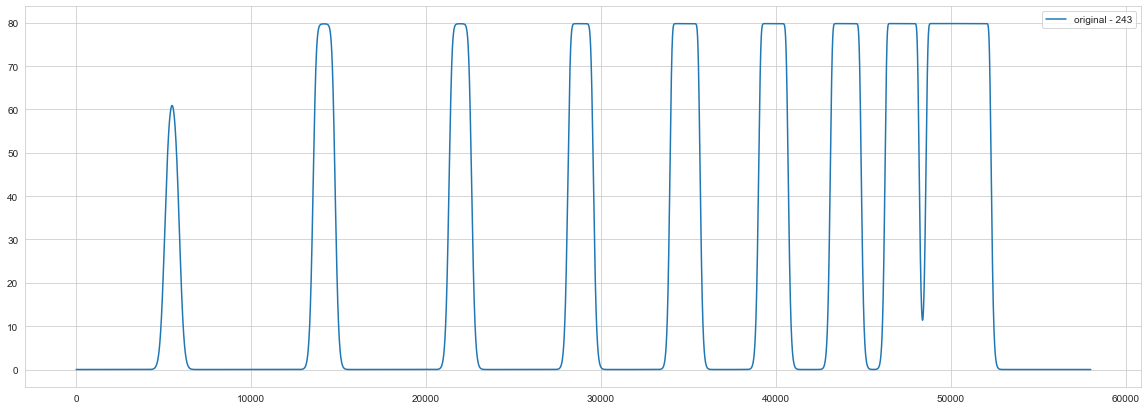

In [29]:
plt.figure(figsize=(20,7))
plt.plot(signal[243], label='original - 243')
plt.legend()
plt.savefig("data/5K_gen_files/original.png")
plt.show()

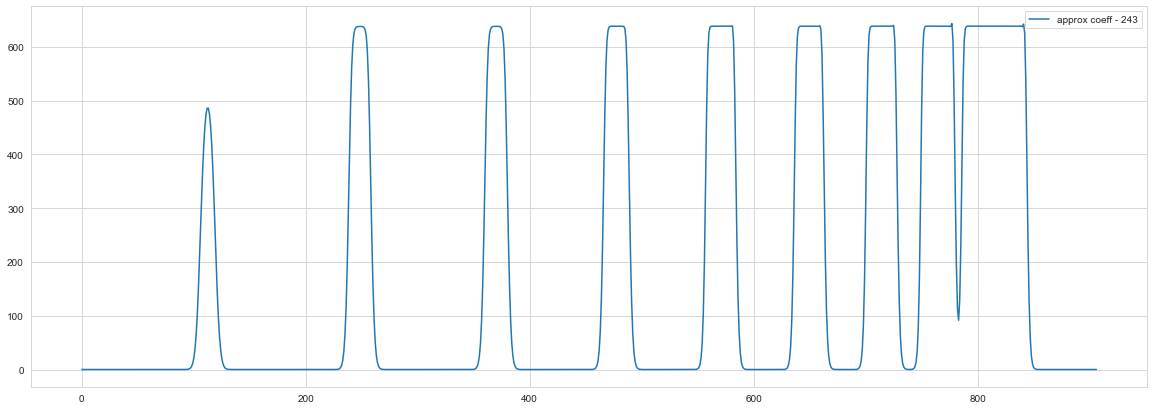

In [30]:
plt.figure(figsize=(20,7))
plt.plot(approx_coeffs[243], label='approx coeff - 243')
plt.legend()
plt.savefig("data/5K_gen_files/approx_level6.png")
plt.show()

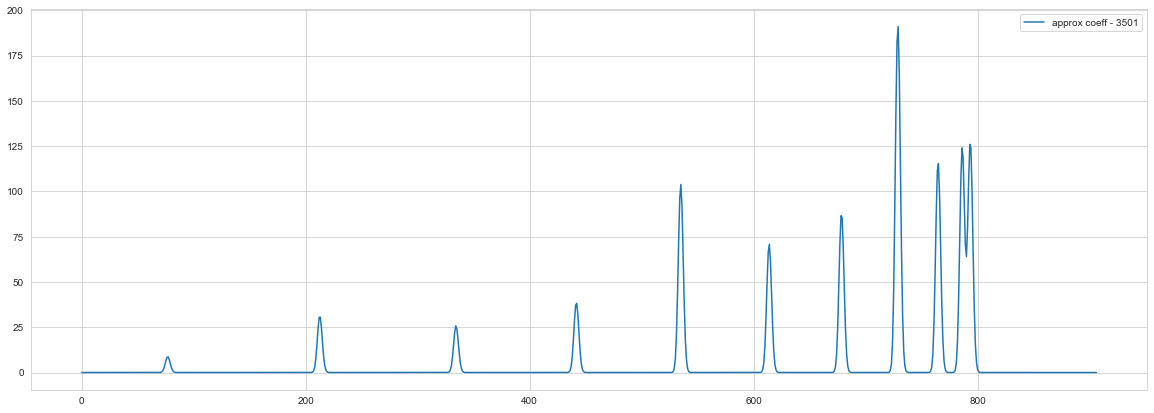

In [31]:
plt.figure(figsize=(20,7))
plt.plot(approx_coeffs[3500], label='approx coeff - 3501')
plt.legend()
# plt.savefig("data/5K_gen_files/approx_level6.png")
plt.show()

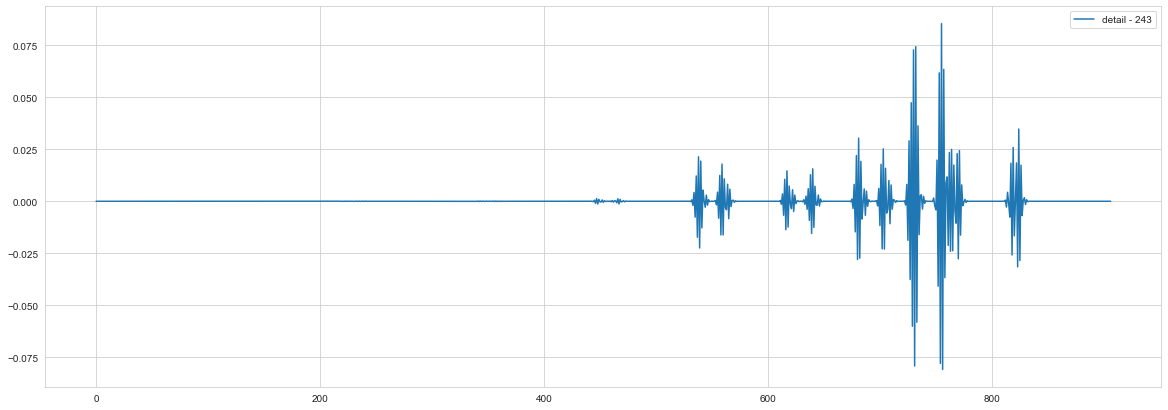

In [32]:
plt.figure(figsize=(20,7))
plt.plot(detail_coeffs[243], label='detail - 243')
plt.legend()
plt.savefig("data/5K_gen_files/detail_level6.png")
plt.show()

In [33]:
features = detail_coeffs
labels_ = df_param

print('feature_shape: ', features.shape, 'labels_shape: ', labels_.shape)


feature_shape:  (5000, 907) labels_shape:  (5000, 6)


In [34]:
# drop the tcmb column
labels_.drop(columns=['tcmb'], inplace=True)

#### save the true params to a file

In [35]:
# get the last 1500 data of the parameters from labels 
df_param = df_param.iloc[-1500:, :]
# save the vals to a csv file
df_param.to_csv("data/5K_gen_files/true_param_vals.csv")
df_param.head()


A         fwhm          ntot      size         tex       vlsr
g                                                            
3500  4.017353  1.046380e+16  2.474728  380.501668  59.235649
3501  5.225158  4.862314e+16  0.517616  180.573273 -43.767623
3502  3.081602  2.694376e+17  1.910270  156.617297  -8.103683
3503  9.023452  1.310160e+17  2.180291  375.240297   4.008605
3504  2.768186  5.450850e+18  1.997846  390.072148  41.127747

In [36]:
df = pd.DataFrame(approx_coeffs)
df.head()

0          1          2          3         4         5         6    \
0   0.000000   0.000000   0.000000   0.000000  0.000000  0.000000  0.000000   
1   0.000000   0.000000   0.000000   0.000000  0.000000  0.000000  0.000000   
2   0.000000   0.000000   0.000000   0.000000  0.000000  0.000000  0.000000   
3   0.173380   0.073349   0.029971   0.011830  0.004511  0.001662  0.000591   
4  50.843837  34.504674  21.402547  12.136648  6.305454  3.009765  1.323374   

        7         8         9    ...         897         898         899  \
0  0.000000  0.000000  0.000000  ...    0.000000    0.000000    0.000000   
1  0.000000  0.000000  0.000000  ...    0.000000    0.000000    0.000000   
2  0.000000  0.000000  0.000000  ...    0.000000    0.000000    0.000000   
3  0.000203  0.000068  0.000022  ...   99.638223   67.934494   42.825013   
4  0.537049  0.201469  0.069869  ...  118.372734  118.634536  118.994559   

          900         901         902         903        904        905  \
0    0.000000    0.000000    0.000000    0.000000   0.000000   0.000000   
1    0.000000    0.000000    0.000000    0.000000   0.000000   0.000000   
2    0.000000    0.000000    0.000000    0.000000   0.000000   0.000000   
3   25.251283   14.069342    7.465895    3.794107   1.853232   0.871994   
4  119.333792  118.747740  115.988429  109.908585  99.793753  85.689683   

         906  
0   0.000000  
1   0.000000  
2   0.000000  
3   0.395758  
4  68.688209  

[5 rows x 907 columns]

In [37]:
df = pd.concat([df, labels_], axis=1)
df.head()

0          1          2          3         4         5         6  \
0   0.000000   0.000000   0.000000   0.000000  0.000000  0.000000  0.000000   
1   0.000000   0.000000   0.000000   0.000000  0.000000  0.000000  0.000000   
2   0.000000   0.000000   0.000000   0.000000  0.000000  0.000000  0.000000   
3   0.173380   0.073349   0.029971   0.011830  0.004511  0.001662  0.000591   
4  50.843837  34.504674  21.402547  12.136648  6.305454  3.009765  1.323374   

          7         8         9  ...         902         903        904  \
0  0.000000  0.000000  0.000000  ...    0.000000    0.000000   0.000000   
1  0.000000  0.000000  0.000000  ...    0.000000    0.000000   0.000000   
2  0.000000  0.000000  0.000000  ...    0.000000    0.000000   0.000000   
3  0.000203  0.000068  0.000022  ...    7.465895    3.794107   1.853232   
4  0.537049  0.201469  0.069869  ...  115.988429  109.908585  99.793753   

         905        906       fwhm          ntot      size         tex  \
0   0.000000   0.000000   2.933735  9.035557e+18  1.332560  131.303629   
1   0.000000   0.000000   6.144747  1.329373e+18  0.388745   68.564338   
2   0.000000   0.000000   5.936799  7.038781e+17  2.270334  306.109908   
3   0.871994   0.395758  10.075154  7.898081e+16  0.465409   53.727434   
4  85.689683  68.688209   6.654279  6.687129e+16  0.464912  374.698519   

        vlsr  
0  17.020590  
1  13.937171  
2  32.571172  
3 -12.442107  
4 -27.878288  

[5 rows x 912 columns]

In [38]:
df.shape

(5000, 912)

In [39]:
# convert the ntot column to log values 
df['ntot'] = np.log10(df['ntot'])
df.head()

0          1          2          3         4         5         6  \
0   0.000000   0.000000   0.000000   0.000000  0.000000  0.000000  0.000000   
1   0.000000   0.000000   0.000000   0.000000  0.000000  0.000000  0.000000   
2   0.000000   0.000000   0.000000   0.000000  0.000000  0.000000  0.000000   
3   0.173380   0.073349   0.029971   0.011830  0.004511  0.001662  0.000591   
4  50.843837  34.504674  21.402547  12.136648  6.305454  3.009765  1.323374   

          7         8         9  ...         902         903        904  \
0  0.000000  0.000000  0.000000  ...    0.000000    0.000000   0.000000   
1  0.000000  0.000000  0.000000  ...    0.000000    0.000000   0.000000   
2  0.000000  0.000000  0.000000  ...    0.000000    0.000000   0.000000   
3  0.000203  0.000068  0.000022  ...    7.465895    3.794107   1.853232   
4  0.537049  0.201469  0.069869  ...  115.988429  109.908585  99.793753   

         905        906       fwhm       ntot      size         tex       vlsr  
0   0.000000   0.000000   2.933735  18.955955  1.332560  131.303629  17.020590  
1   0.000000   0.000000   6.144747  18.123647  0.388745   68.564338  13.937171  
2   0.000000   0.000000   5.936799  17.847497  2.270334  306.109908  32.571172  
3   0.871994   0.395758  10.075154  16.897522  0.465409   53.727434 -12.442107  
4  85.689683  68.688209   6.654279  16.825240  0.464912  374.698519 -27.878288  

[5 rows x 912 columns]

In [40]:
X = df.iloc[:, :907]
y = df.iloc[:, -5:]

In [41]:
X

0          1          2          3         4             5    \
0      0.000000   0.000000   0.000000   0.000000  0.000000  0.000000e+00   
1      0.000000   0.000000   0.000000   0.000000  0.000000  0.000000e+00   
2      0.000000   0.000000   0.000000   0.000000  0.000000  0.000000e+00   
3      0.173380   0.073349   0.029971   0.011830  0.004511  1.661509e-03   
4     50.843837  34.504674  21.402547  12.136648  6.305454  3.009765e+00   
...         ...        ...        ...        ...       ...           ...   
4995   0.000189   0.000055   0.000015   0.000004  0.000001  2.649288e-07   
4996   0.000000   0.000000   0.000000   0.000000  0.000000  0.000000e+00   
4997   0.003163   0.000686   0.000134   0.000024  0.000004  5.559667e-07   
4998  51.699785   7.770424   0.698719   0.038455  0.001311  2.765760e-05   
4999   0.000000   0.000000   0.000000   0.000000  0.000000  0.000000e+00   

               6             7             8             9    ...  \
0     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...   
1     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...   
2     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...   
3     5.912702e-04  2.032714e-04  6.752390e-05  2.165531e-05  ...   
4     1.323374e+00  5.370486e-01  2.014693e-01  6.986887e-02  ...   
...            ...           ...           ...           ...  ...   
4995  6.315852e-08  1.446928e-08  3.185582e-09  6.739230e-10  ...   
4996  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...   
4997  7.307189e-08  8.693087e-09  9.361825e-10  9.127316e-11  ...   
4998  3.570129e-07  2.770732e-09  1.267249e-11  3.342662e-14  ...   
4999  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...   

               897           898           899         900         901  \
0     0.000000e+00  0.000000e+00  0.000000e+00    0.000000    0.000000   
1     0.000000e+00  0.000000e+00  0.000000e+00    0.000000    0.000000   
2     0.000000e+00  0.000000e+00  0.000000e+00    0.000000    0.000000   
3     9.963822e+01  6.793449e+01  4.282501e+01   25.251283   14.069342   
4     1.183727e+02  1.186345e+02  1.189946e+02  119.333792  118.747740   
...            ...           ...           ...         ...         ...   
4995  4.797437e+00  2.088690e+00  8.723376e-01    0.349765    0.134686   
4996  0.000000e+00  0.000000e+00  0.000000e+00    0.000000    0.000000   
4997  4.881189e+01  2.992135e+01  1.645938e+01    8.129749    3.610308   
4998  5.373853e+02  3.845887e+02  1.659364e+02   10.733569   94.478318   
4999  5.894447e-21  1.557509e-24  4.157107e-31    0.000000    0.000000   

             902         903         904         905         906  
0       0.000000    0.000000    0.000000    0.000000    0.000000  
1       0.000000    0.000000    0.000000    0.000000    0.000000  
2       0.000000    0.000000    0.000000    0.000000    0.000000  
3       7.465895    3.794107    1.853232    0.871994    0.395758  
4     115.988429  109.908585   99.793753   85.689683   68.688209  
...          ...         ...         ...         ...         ...  
4995    0.049820    0.017704    0.006045    0.001983    0.000625  
4996    0.000000    0.000000    0.000000    0.000000    0.000000  
4997    1.443573    0.520352    0.169251    0.049710    0.013190  
4998  328.378769  465.765440  542.502199  435.227857  199.732013  
4999    0.000000    0.000000    0.000000    0.000000    0.000000  

[5000 rows x 907 columns]

In [42]:
y

fwhm       ntot      size         tex       vlsr
0      2.933735  18.955955  1.332560  131.303629  17.020590
1      6.144747  18.123647  0.388745   68.564338  13.937171
2      5.936799  17.847497  2.270334  306.109908  32.571172
3     10.075154  16.897522  0.465409   53.727434 -12.442107
4      6.654279  16.825240  0.464912  374.698519 -27.878288
...         ...        ...       ...         ...        ...
4995   9.338413  16.937575  1.757227   55.665013  -7.712418
4996   2.149973  17.047672  0.837656  323.015585  32.306313
4997   5.734476  16.173857  2.080488  397.491328 -20.459207
4998   2.180272  16.909169  1.276969  380.102187 -29.312512
4999   6.160789  17.115855  0.594107  317.478835   2.207556

[5000 rows x 5 columns]

#### split the data into the training and test set

In [43]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    shuffle=False,
    random_state=42
    )

print('X_train shape: ',  X_train.shape, '\n',
    'y_train shape: ', y_train.shape, '\n',
    'X_test shape: ', X_test.shape, '\n',
    'y_test shape: ', y_test.shape)

X_train shape:  (3500, 907) 
 y_train shape:  (3500, 5) 
 X_test shape:  (1500, 907) 
 y_test shape:  (1500, 5)


## 1. Multioutput Regressor - RF

In [44]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

# tuned model to use instantly
regr_multirf = MultiOutputRegressor(
    estimator=RandomForestRegressor(
        bootstrap='False',
        max_depth=90,
        max_features='log2',
        max_samples=0.8999999999999999,
        n_estimators=700,
        n_jobs=-1,
        random_state=7,
        verbose=2
))

# # from tuned model
# regr_multirf = MultiOutputRegressor(
#     estimator=RandomForestRegressor(
#        n_estimators=800, 
#        min_samples_split=2,
#        min_samples_leaf=1,
#        max_features='auto', 
#        max_depth=130,
#        bootstrap=True,
#        verbose=42
#     )
# )


# multioutput regressor+
regr_multirf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 7 of 700
building tree 3 of 700building tree 1 of 700
building tree 2 of 700
building tree 4 of 700
building tree 6 of 700

building tree 5 of 700
building tree 8 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 9 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 20 of 700
building tree 18 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700
building tree 28 of 700
building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
b

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.0s


building tree 49 of 700
building tree 51 of 700
building tree 52 of 700
building tree 53 of 700
building tree 50 of 700
building tree 54 of 700
building tree 55 of 700
building tree 56 of 700
building tree 57 of 700
building tree 59 of 700
building tree 61 of 700
building tree 63 of 700
building tree 65 of 700
building tree 67 of 700
building tree 69 of 700
building tree 58 of 700
building tree 71 of 700
building tree 64 of 700
building tree 60 of 700
building tree 72 of 700
building tree 62 of 700
building tree 68 of 700
building tree 66 of 700
building tree 70 of 700
building tree 73 of 700
building tree 77 of 700
building tree 79 of 700
building tree 75 of 700
building tree 81 of 700
building tree 83 of 700
building tree 85 of 700
building tree 87 of 700
building tree 80 of 700
building tree 74 of 700
building tree 78 of 700
building tree 76 of 700
building tree 82 of 700
building tree 84 of 700
building tree 86 of 700
building tree 88 of 700
building tree 89 of 700
building tree 10

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   11.7s


building tree 413 of 700
building tree 407 of 700
building tree 404 of 700
building tree 400 of 700
building tree 396 of 700
building tree 410 of 700
building tree 414 of 700
building tree 408 of 700
building tree 411 of 700
building tree 421 of 700
building tree 425 of 700
building tree 429 of 700
building tree 417 of 700
building tree 415 of 700
building tree 433 of 700
building tree 437 of 700
building tree 426 of 700
building tree 418 of 700
building tree 422 of 700
building tree 430 of 700
building tree 434 of 700
building tree 412 of 700
building tree 416 of 700
building tree 438 of 700
building tree 423 of 700
building tree 427 of 700
building tree 435 of 700
building tree 431 of 700
building tree 419 of 700
building tree 428 of 700
building tree 439 of 700
building tree 420 of 700
building tree 441 of 700
building tree 432 of 700
building tree 424 of 700
building tree 436 of 700
building tree 445 of 700
building tree 442 of 700
building tree 440 of 700
building tree 449 of 700


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:   13.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 3 of 700
building tree 4 of 700
building tree 1 of 700
building tree 2 of 700
building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 31 of 700
building tree 20 of 700
building tree 18 of 700
building tree 22 of 700
building tree 26 of 700
building tree 30 of 700
building tree 28 of 700
building tree 24 of 700
building tree 32 of 700
building tree 33 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 45 of 700
building tree 47 of 700
building tree 44 of 700
building tree 42 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s


building tree 65 of 700
building tree 67 of 700
building tree 69 of 700
building tree 71 of 700
building tree 73 of 700
building tree 75 of 700
building tree 77 of 700
building tree 79 of 700
building tree 66 of 700
building tree 68 of 700
building tree 72 of 700
building tree 70 of 700
building tree 78 of 700
building tree 76 of 700
building tree 74 of 700
building tree 80 of 700
building tree 81 of 700
building tree 83 of 700
building tree 85 of 700
building tree 87 of 700
building tree 89 of 700
building tree 91 of 700
building tree 86 of 700
building tree 93 of 700
building tree 95 of 700
building tree 82 of 700
building tree 84 of 700
building tree 88 of 700
building tree 90 of 700
building tree 96 of 700
building tree 94 of 700
building tree 92 of 700
building tree 97 of 700
building tree 99 of 700
building tree 101 of 700
building tree 103 of 700
building tree 105 of 700
building tree 107 of 700
building tree 109 of 700
building tree 111 of 700
building tree 98 of 700
building t

[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    3.2s


building tree 292 of 700
building tree 299 of 700
building tree 301 of 700
building tree 303 of 700
building tree 294 of 700
building tree 302 of 700
building tree 298 of 700
building tree 300 of 700
building tree 305 of 700
building tree 307 of 700
building tree 296 of 700
building tree 309 of 700
building tree 304 of 700
building tree 311 of 700
building tree 310 of 700
building tree 308 of 700
building tree 306 of 700
building tree 312 of 700
building tree 315 of 700
building tree 317 of 700
building tree 313 of 700
building tree 319 of 700
building tree 314 of 700
building tree 320 of 700
building tree 318 of 700
building tree 316 of 700
building tree 321 of 700
building tree 323 of 700
building tree 325 of 700
building tree 327 of 700
building tree 329 of 700
building tree 322 of 700
building tree 324 of 700
building tree 331 of 700
building tree 333 of 700
building tree 326 of 700
building tree 335 of 700
building tree 328 of 700
building tree 330 of 700
building tree 337 of 700


[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    8.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 2 of 700
building tree 1 of 700
building tree 8 of 700
building tree 5 of 700
building tree 7 of 700
building tree 3 of 700
building tree 6 of 700
building tree 4 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 31 of 700
building tree 24 of 700
building tree 18 of 700
building tree 32 of 700
building tree 20 of 700
building tree 22 of 700
building tree 26 of 700
building tree 30 of 700
building tree 28 of 700
building tree 33 of 700
building tree 35 of 700
building tree 39 of 700
building tree 37 of 700
building tree 41 of 700
building tree 43 of 700
building tree 45 of 700
building tree 47 of 700
building tree 40 of 700
building tree 34 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s


building tree 49 of 700
building tree 53 of 700
building tree 55 of 700
building tree 57 of 700
building tree 51 of 700
building tree 50 of 700
building tree 61 of 700
building tree 59 of 700
building tree 63 of 700
building tree 52 of 700
building tree 62 of 700
building tree 58 of 700
building tree 54 of 700
building tree 56 of 700
building tree 60 of 700
building tree 64 of 700
building tree 65 of 700
building tree 67 of 700
building tree 69 of 700
building tree 71 of 700
building tree 73 of 700
building tree 75 of 700
building tree 77 of 700
building tree 72 of 700
building tree 68 of 700
building tree 66 of 700
building tree 70 of 700
building tree 74 of 700
building tree 76 of 700
building tree 79 of 700
building tree 78 of 700
building tree 81 of 700
building tree 83 of 700
building tree 85 of 700
building tree 87 of 700
building tree 80 of 700
building tree 89 of 700
building tree 91 of 700
building tree 93 of 700
building tree 82 of 700
building tree 84 of 700
building tree 95

[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    3.1s


building tree 299 of 700
building tree 301 of 700
building tree 296 of 700
building tree 300 of 700
building tree 303 of 700
building tree 298 of 700
building tree 305 of 700
building tree 294 of 700
building tree 307 of 700
building tree 302 of 700
building tree 304 of 700
building tree 309 of 700
building tree 306 of 700
building tree 308 of 700
building tree 311 of 700
building tree 313 of 700
building tree 315 of 700
building tree 317 of 700
building tree 319 of 700
building tree 316 of 700
building tree 312 of 700
building tree 314 of 700
building tree 310 of 700
building tree 321 of 700
building tree 318 of 700
building tree 323 of 700
building tree 320 of 700
building tree 325 of 700
building tree 327 of 700
building tree 329 of 700
building tree 331 of 700
building tree 322 of 700
building tree 324 of 700
building tree 333 of 700
building tree 335 of 700
building tree 326 of 700
building tree 328 of 700
building tree 330 of 700
building tree 332 of 700
building tree 334 of 700


[Parallel(n_jobs=-1)]: Done 681 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 685 out of 700 | elapsed:    7.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    7.8s finished


building tree 699 of 700
building tree 698 of 700
building tree 700 of 700


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 3 of 700building tree 6 of 700
building tree 7 of 700building tree 5 of 700

building tree 4 of 700
building tree 2 of 700

building tree 1 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700building tree 11 of 700

building tree 12 of 700
building tree 15 of 700
building tree 16 of 700
building tree 14 of 700
building tree 13 of 700
building tree 17 of 700
building tree 18 of 700
building tree 21 of 700
building tree 22 of 700
building tree 19 of 700
building tree 23 of 700
building tree 27 of 700building tree 25 of 700

building tree 31 of 700
building tree 29 of 700
building tree 20 of 700
building tree 24 of 700
building tree 33 of 700
building tree 28 of 700
building tree 26 of 700
building tree 30 of 700
building tree 32 of 700
building tree 35 of 700
building tree 34 of 700
building tree 37 of 700
building tree 36 of 700
building tree 39 of 700
building tree 38 of 700
building tree 41 of 700building tree 45 of 700
building tree 47 of 700

b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s


building tree 57 of 700
building tree 61 of 700
building tree 54 of 700
building tree 51 of 700
building tree 65 of 700
building tree 55 of 700
building tree 62 of 700
building tree 58 of 700
building tree 52 of 700
building tree 69 of 700
building tree 73 of 700
building tree 77 of 700
building tree 56 of 700
building tree 59 of 700
building tree 63 of 700
building tree 66 of 700
building tree 78 of 700
building tree 70 of 700
building tree 67 of 700
building tree 60 of 700
building tree 74 of 700
building tree 64 of 700
building tree 81 of 700
building tree 85 of 700
building tree 68 of 700
building tree 71 of 700
building tree 82 of 700
building tree 79 of 700
building tree 89 of 700
building tree 75 of 700
building tree 83 of 700
building tree 86 of 700
building tree 72 of 700
building tree 76 of 700
building tree 80 of 700
building tree 90 of 700
building tree 93 of 700
building tree 97 of 700
building tree 87 of 700
building tree 84 of 700
building tree 101 of 700
building tree 9

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.7s


building tree 532 of 700
building tree 542 of 700
building tree 524 of 700
building tree 536 of 700
building tree 546 of 700
building tree 540 of 700
building tree 543 of 700
building tree 549 of 700
building tree 553 of 700
building tree 557 of 700
building tree 561 of 700
building tree 544 of 700
building tree 565 of 700
building tree 547 of 700
building tree 558 of 700
building tree 569 of 700
building tree 550 of 700
building tree 562 of 700
building tree 554 of 700
building tree 548 of 700
building tree 551 of 700
building tree 566 of 700
building tree 555 of 700
building tree 559 of 700
building tree 570 of 700
building tree 573 of 700
building tree 563 of 700
building tree 577 of 700
building tree 567 of 700
building tree 552 of 700
building tree 560 of 700
building tree 571 of 700
building tree 556 of 700
building tree 574 of 700
building tree 564 of 700
building tree 568 of 700
building tree 578 of 700
building tree 575 of 700
building tree 572 of 700
building tree 579 of 700


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 2 of 700building tree 5 of 700

building tree 4 of 700
building tree 7 of 700
building tree 1 of 700
building tree 3 of 700
building tree 6 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 18 of 700
building tree 20 of 700
building tree 22 of 700
building tree 24 of 700
building tree 27 of 700
building tree 29 of 700
building tree 31 of 700
building tree 26 of 700
building tree 33 of 700
building tree 35 of 700
building tree 28 of 700
building tree 37 of 700
building tree 30 of 700
building tree 32 of 700
building tree 39 of 700
building tree 41 of 700
building tree 34 of 700
building tree 43 of 700
building tree 38 of 700
building tree 36 of 700
building tree 45 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


building tree 65 of 700
building tree 69 of 700
building tree 50 of 700
building tree 73 of 700
building tree 77 of 700
building tree 58 of 700
building tree 54 of 700
building tree 62 of 700
building tree 66 of 700
building tree 51 of 700
building tree 74 of 700
building tree 70 of 700
building tree 78 of 700
building tree 59 of 700
building tree 63 of 700
building tree 55 of 700
building tree 52 of 700
building tree 75 of 700
building tree 67 of 700
building tree 79 of 700
building tree 71 of 700
building tree 64 of 700
building tree 60 of 700
building tree 56 of 700
building tree 68 of 700
building tree 76 of 700
building tree 80 of 700
building tree 72 of 700
building tree 81 of 700
building tree 85 of 700
building tree 89 of 700
building tree 93 of 700
building tree 82 of 700
building tree 86 of 700
building tree 90 of 700
building tree 101 of 700
building tree 97 of 700
building tree 105 of 700
building tree 98 of 700
building tree 102 of 700
building tree 94 of 700
building tree

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.3s


building tree 553 of 700
building tree 557 of 700
building tree 543 of 700
building tree 550 of 700
building tree 535 of 700
building tree 554 of 700
building tree 558 of 700
building tree 547 of 700
building tree 539 of 700
building tree 551 of 700
building tree 536 of 700
building tree 544 of 700
building tree 555 of 700
building tree 548 of 700
building tree 559 of 700
building tree 540 of 700
building tree 561 of 700
building tree 552 of 700
building tree 556 of 700
building tree 560 of 700
building tree 562 of 700
building tree 565 of 700
building tree 569 of 700
building tree 563 of 700
building tree 566 of 700
building tree 564 of 700
building tree 573 of 700
building tree 577 of 700
building tree 581 of 700
building tree 570 of 700
building tree 585 of 700
building tree 567 of 700
building tree 571 of 700
building tree 582 of 700
building tree 578 of 700
building tree 574 of 700
building tree 586 of 700
building tree 568 of 700
building tree 572 of 700
building tree 579 of 700


[Parallel(n_jobs=-1)]: Done 685 out of 700 | elapsed:    4.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    4.4s finished


MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap='False',
                                                     max_depth=90,
                                                     max_features='log2',
                                                     max_samples=0.8999999999999999,
                                                     n_estimators=700,
                                                     n_jobs=-1, random_state=7,
                                                     verbose=2))

In [45]:
#  predict on the new test data
y_multirf_pred = regr_multirf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(

In [46]:
regr_multirf.score(X_test, y_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(

0.7982114135260912

### save the predicted parameters to a csv file 

In [47]:
param_df_rf = pd.DataFrame(y_multirf_pred, columns=['fwhm_pred_rf', 'ntot_pred_rf', 'size_pred_rf', 'tex_pred_rf', 'vlsr_pred_rf'], index=X_test.index)
param_df_rf.head()

fwhm_pred_rf  ntot_pred_rf  size_pred_rf  tex_pred_rf  vlsr_pred_rf
3500      3.389859     16.477943      0.805267   216.010099     57.282138
3501      4.867280     16.555823      1.073249   248.997282    -43.952491
3502      3.194154     17.915443      2.006216   173.567788     -8.218963
3503      8.684477     17.424535      1.341710   269.347861      3.906293
3504      3.074224     17.959467      1.965107   233.294233     41.250847

In [48]:
# convert back the log to linear values 
param_df_rf['ntot_pred_rf'] = np.array(10**param_df_rf['ntot_pred_rf'])

In [49]:
param_df_rf.to_csv('data/5K_gen_files/predicted_parameters_rf.csv', index=True)
param_df_rf.shape

(1500, 5)

In [50]:
pred_para = pd.read_csv('data/5K_gen_files/predicted_parameters_rf.csv')
true_para = pd.read_csv('data/5K_gen_files/true_param_vals.csv')

# add the predicted value to the true value dataframe as new columns separated by an empty column 
true_para = pd.concat([true_para,  pd.DataFrame(np.zeros(len(true_para))), pred_para], axis=1)
true_para.to_csv('data/5K_gen_files/true_param_vals_with_predicted_rf.csv')
true_para.head()

g      fwhm          ntot      size         tex       vlsr    0  \
0  3500  4.017353  1.046380e+16  2.474728  380.501668  59.235649  0.0   
1  3501  5.225158  4.862314e+16  0.517616  180.573273 -43.767623  0.0   
2  3502  3.081602  2.694376e+17  1.910270  156.617297  -8.103683  0.0   
3  3503  9.023452  1.310160e+17  2.180291  375.240297   4.008605  0.0   
4  3504  2.768186  5.450850e+18  1.997846  390.072148  41.127747  0.0   

   Unnamed: 0  fwhm_pred_rf  ntot_pred_rf  size_pred_rf  tex_pred_rf  \
0        3500      3.389859  3.005684e+16      0.805267   216.010099   
1        3501      4.867280  3.596032e+16      1.073249   248.997282   
2        3502      3.194154  8.230817e+17      2.006216   173.567788   
3        3503      8.684477  2.657876e+17      1.341710   269.347861   
4        3504      3.074224  9.108913e+17      1.965107   233.294233   

   vlsr_pred_rf  
0     57.282138  
1    -43.952491  
2     -8.218963  
3      3.906293  
4     41.250847

#### Metrics

In [51]:
class RegressionMetrics:
    def __init__(self):
        self.metrics = {
            "mae": self._mean_absolute_error,
            "mse": self._mean_squared_error,
            "rmse": self._root_mean_squared_error,
            "mape": self._mean_absolute_percentage_error,
            "r2": self._r2_score,
            "msle": self._mean_squared_log_error,
            # "rmsle": self._root_mean_squared_logarithmic_error,
        }

    def get_metric(self, metric,  y_true, y_pred):
        if metric not in self.metrics:
            raise Exception("Metric not found")
        
        if metric == "mae":
            return self._mean_absolute_error(y_true, y_pred)
        if metric == "mse":
            return self._mean_squared_error(y_true, y_pred)
        if metric == "rmse":
            return self._root_mean_squared_error(y_true, y_pred)
        if metric == "mape":
            return self._mean_absolute_percentage_error(y_true, y_pred)
        if metric == "r2":
            return self._r2_score(y_true, y_pred)
        if metric == "msle":
            return self._mean_squared_log_error(y_true, y_pred)
        # if metric == "rmsle":
        #     return self._root_mean_squared_logarithmic_error(y_true, y_pred)
        
    @staticmethod
    def _mean_absolute_error(y_true, y_pred):
        return metrics.mean_absolute_error(y_true, y_pred)

    @staticmethod
    def _mean_squared_error(y_true, y_pred):
        return metrics.mean_squared_error(y_true, y_pred)

    def _root_mean_squared_error(self, y_true, y_pred):
        return np.sqrt(metrics.mean_squared_error(y_true, y_pred))

    def _mean_absolute_percentage_error(self, y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    @staticmethod
    def _r2_score(y_true, y_pred):
        return metrics.r2_score(y_true, y_pred)
    
    def _mean_squared_log_error(self, y_true, y_pred):
        return np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    
    # TODO: investigate in the case where it gives an error
    # def _root_mean_squared_logarithmic_error(self, y_true, y_pred):
    #     return np.sqrt(np.mean(np.square(np.log(y_pred + 1) - np.log(y_true + 1))))


In [52]:
# get the metricl for the multirf regressor
metrics_multirf = RegressionMetrics()
_metrics = ['mae', 'mse', 'rmse', 'mape', 'r2', 'msle']
for metric in _metrics:
    print("Multirf  {}: ".format(metric), metrics_multirf.get_metric(metric, y_test, y_multirf_pred))

Multirf  mae:  11.426202710204246
Multirf  mse:  914.0155258207348
Multirf  rmse:  30.232689688824163
Multirf  mape:  fwhm    11.538984
ntot     2.053553
size    29.602453
tex     38.340201
vlsr     5.157405
dtype: float64
Multirf  r2:  0.7982114135260912
Multirf  msle:  30.232689688824163


### Predicted vs True values plots

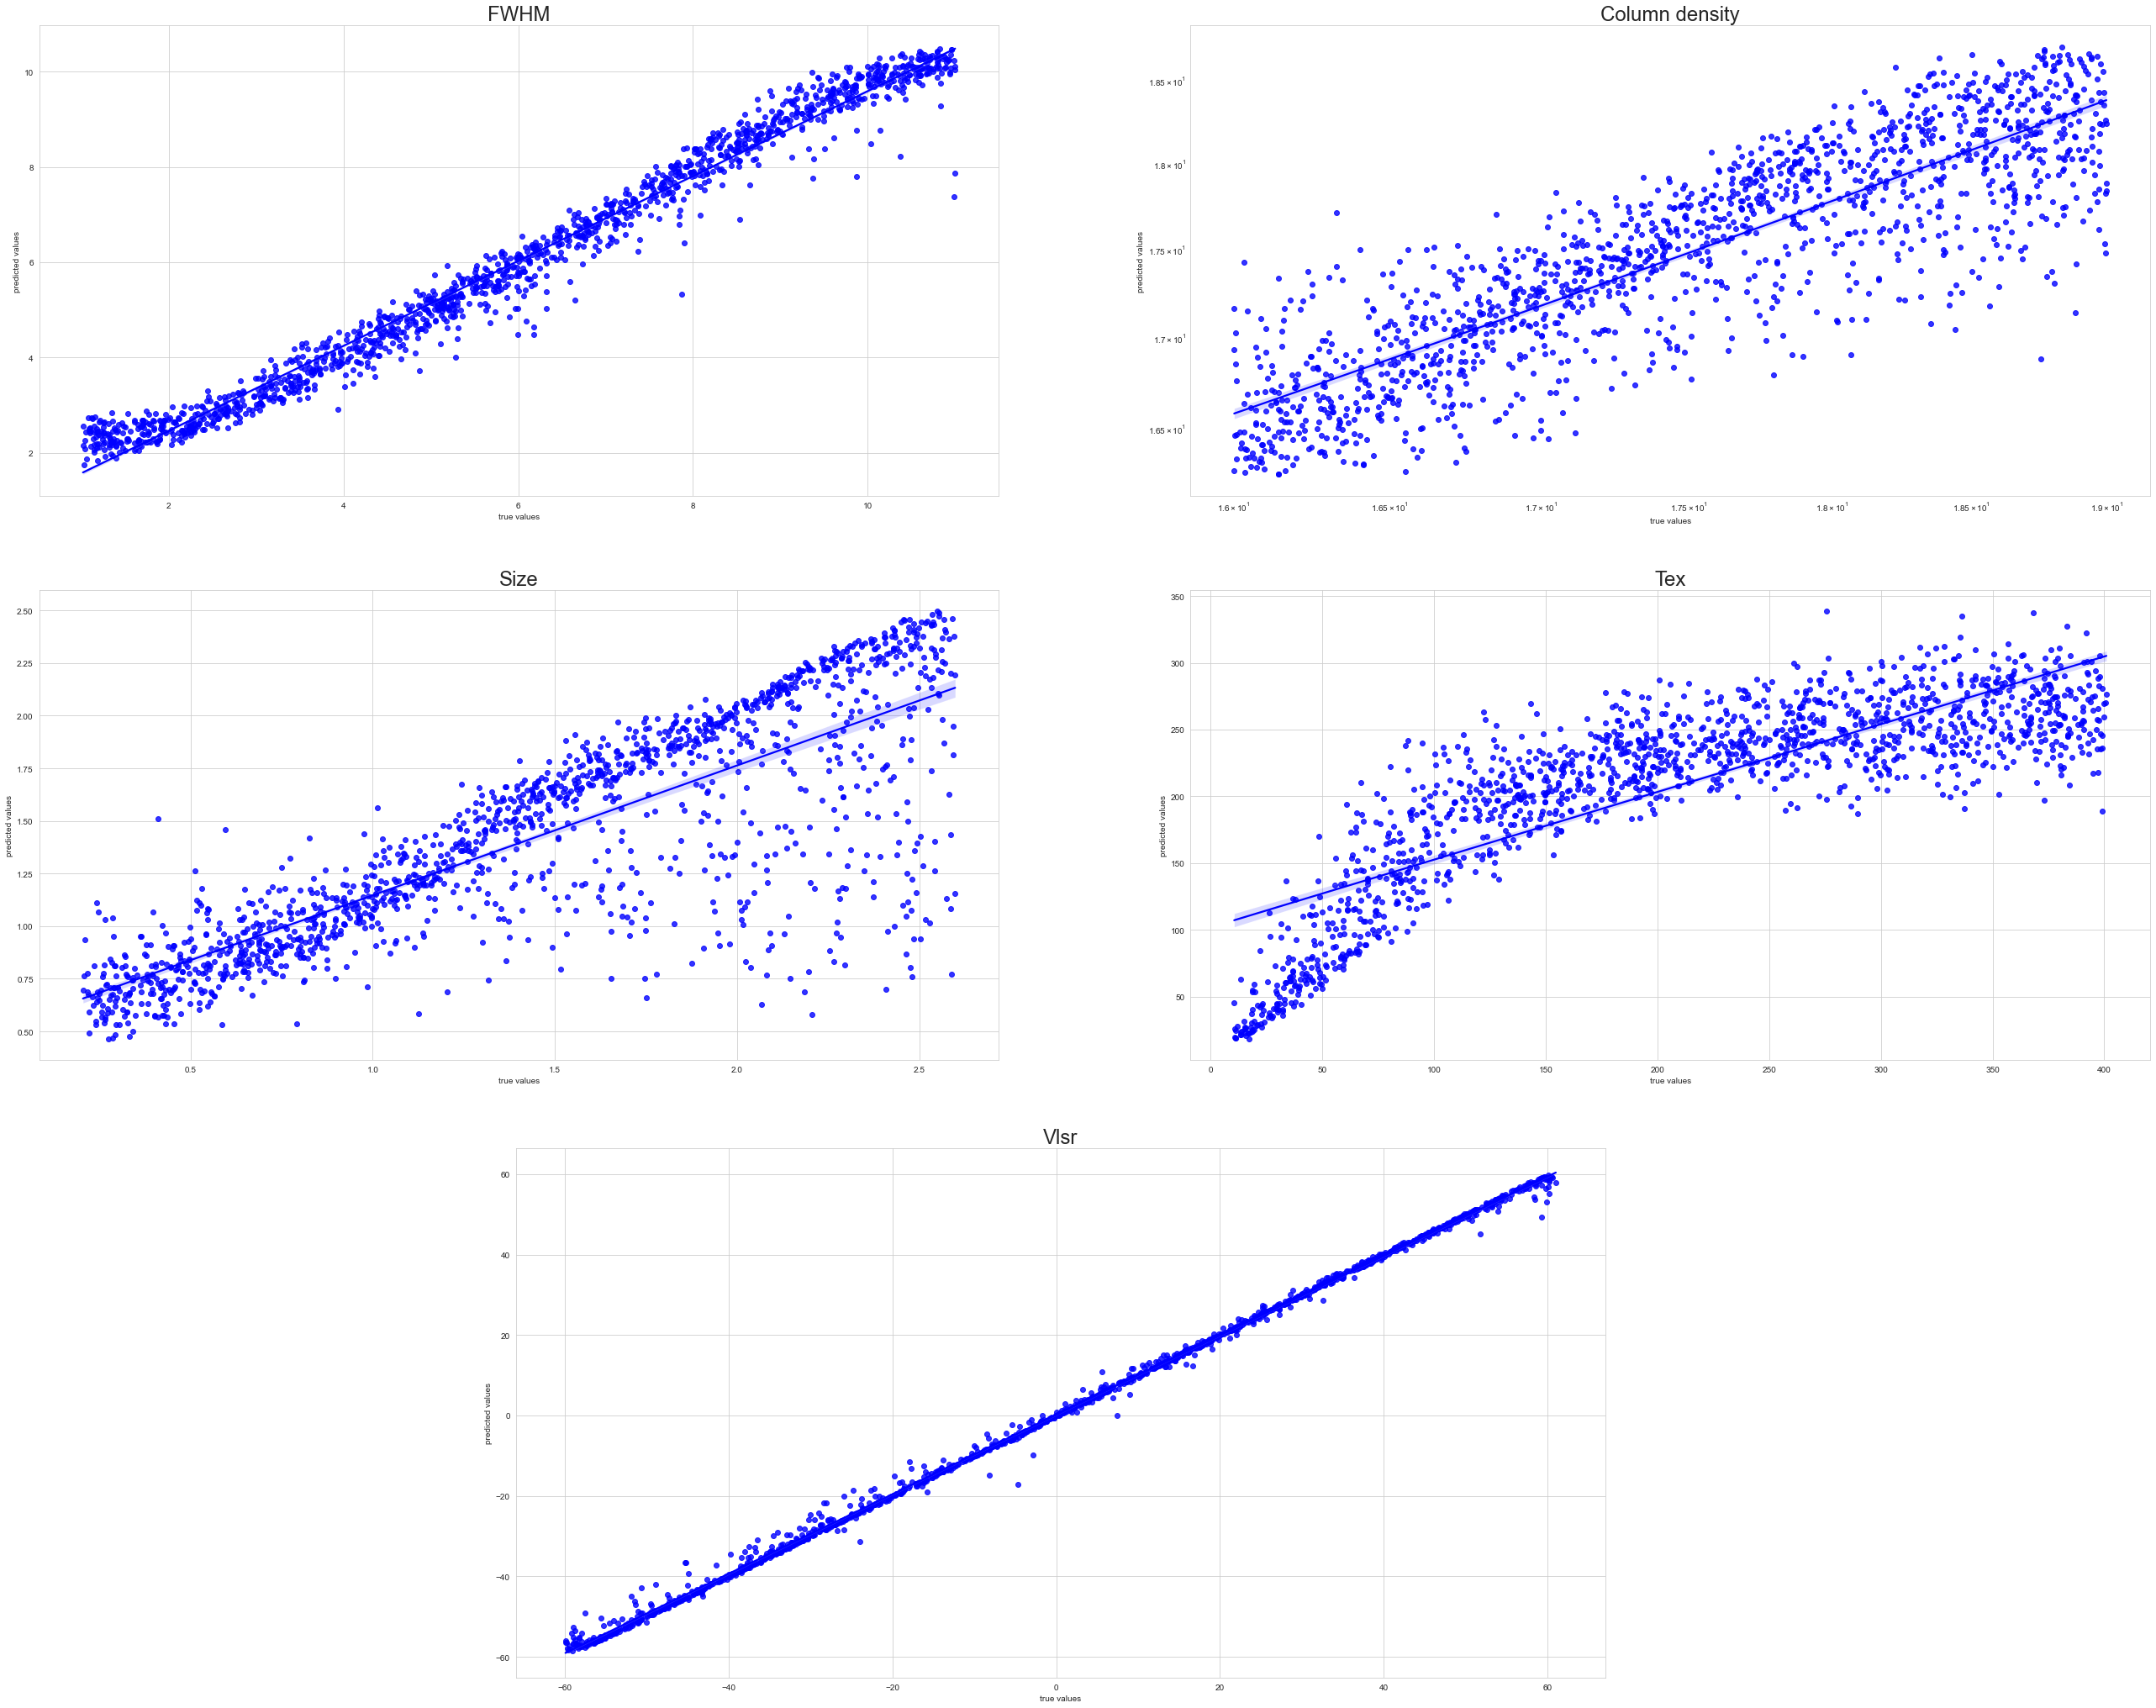

In [53]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

g1 = sns.regplot(x=y_test.iloc[:,0], y=y_multirf_pred[:,0], color='blue', ax=axes[0,0]) # fwhm
g2 = sns.regplot(x=y_test.iloc[:,1], y=y_multirf_pred[:,1], color='blue', ax=axes[0,1]) # column density
g3 = sns.regplot(x=y_test.iloc[:,2], y=y_multirf_pred[:,2], color='blue', ax=axes[1,0]) # size
g4 = sns.regplot(x=y_test.iloc[:,3], y=y_multirf_pred[:,3], color='blue', ax=axes[1,1]) # tex
g5 = sns.regplot(x=y_test.iloc[:,4], y=y_multirf_pred[:,4], color='blue', ax=axes[2,0]) # vlsr

g1.set(title='FWHM', ylabel="predicted values", xlabel="true values")
g2.set(title='Column density', ylabel="predicted values", xlabel="true values", xscale='log', yscale='log')
g3.set(title='Size', ylabel="predicted values", xlabel="true values")
g4.set(title='Tex', ylabel="predicted values", xlabel="true values")
g5.set(title='Vlsr', ylabel="predicted values", xlabel="true values")

plt.savefig("data/5K_gen_files/pred_true_5K_RF.png")
plt.show()

### 3D plots -  Columnn density, Excitation temperature and Size

In [54]:
pred_param_rf = pd.DataFrame(y_multirf_pred, columns=['fwhm', 'ntot', 'size', 'tex', 'vlsr'])
pred_param_rf.head()

fwhm       ntot      size         tex       vlsr
0  3.389859  16.477943  0.805267  216.010099  57.282138
1  4.867280  16.555823  1.073249  248.997282 -43.952491
2  3.194154  17.915443  2.006216  173.567788  -8.218963
3  8.684477  17.424535  1.341710  269.347861   3.906293
4  3.074224  17.959467  1.965107  233.294233  41.250847

### Residuals 3D plot -  Random Forest Regressor

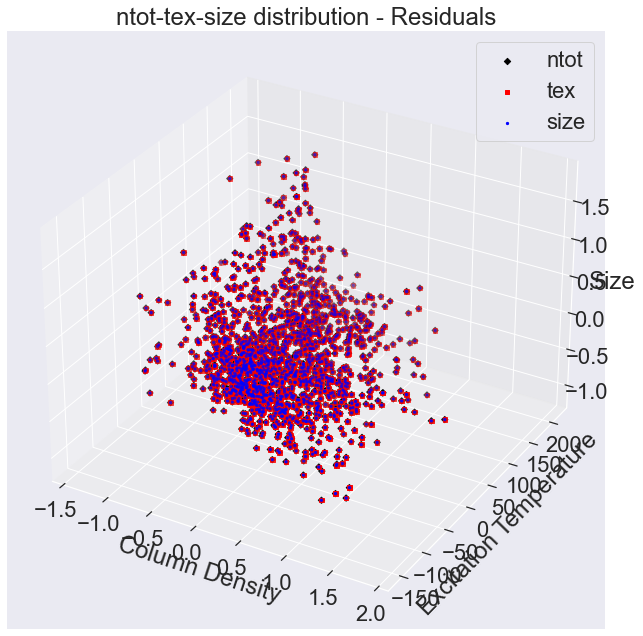

In [55]:
fig = plt.figure(figsize=(26, 11))
plt.setp(ax.get_xticklabels(), fontsize=12)
ax1 = fig.add_subplot(121, projection='3d')

markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']

residuals_rf = (y_test - y_multirf_pred)
# residuals
x1 = residuals_rf['ntot']
y1 = residuals_rf['tex']
z1 = residuals_rf['size']

for i in range(len(markers)):
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Residuals')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')
plt.legend(loc="best")
plt.show()

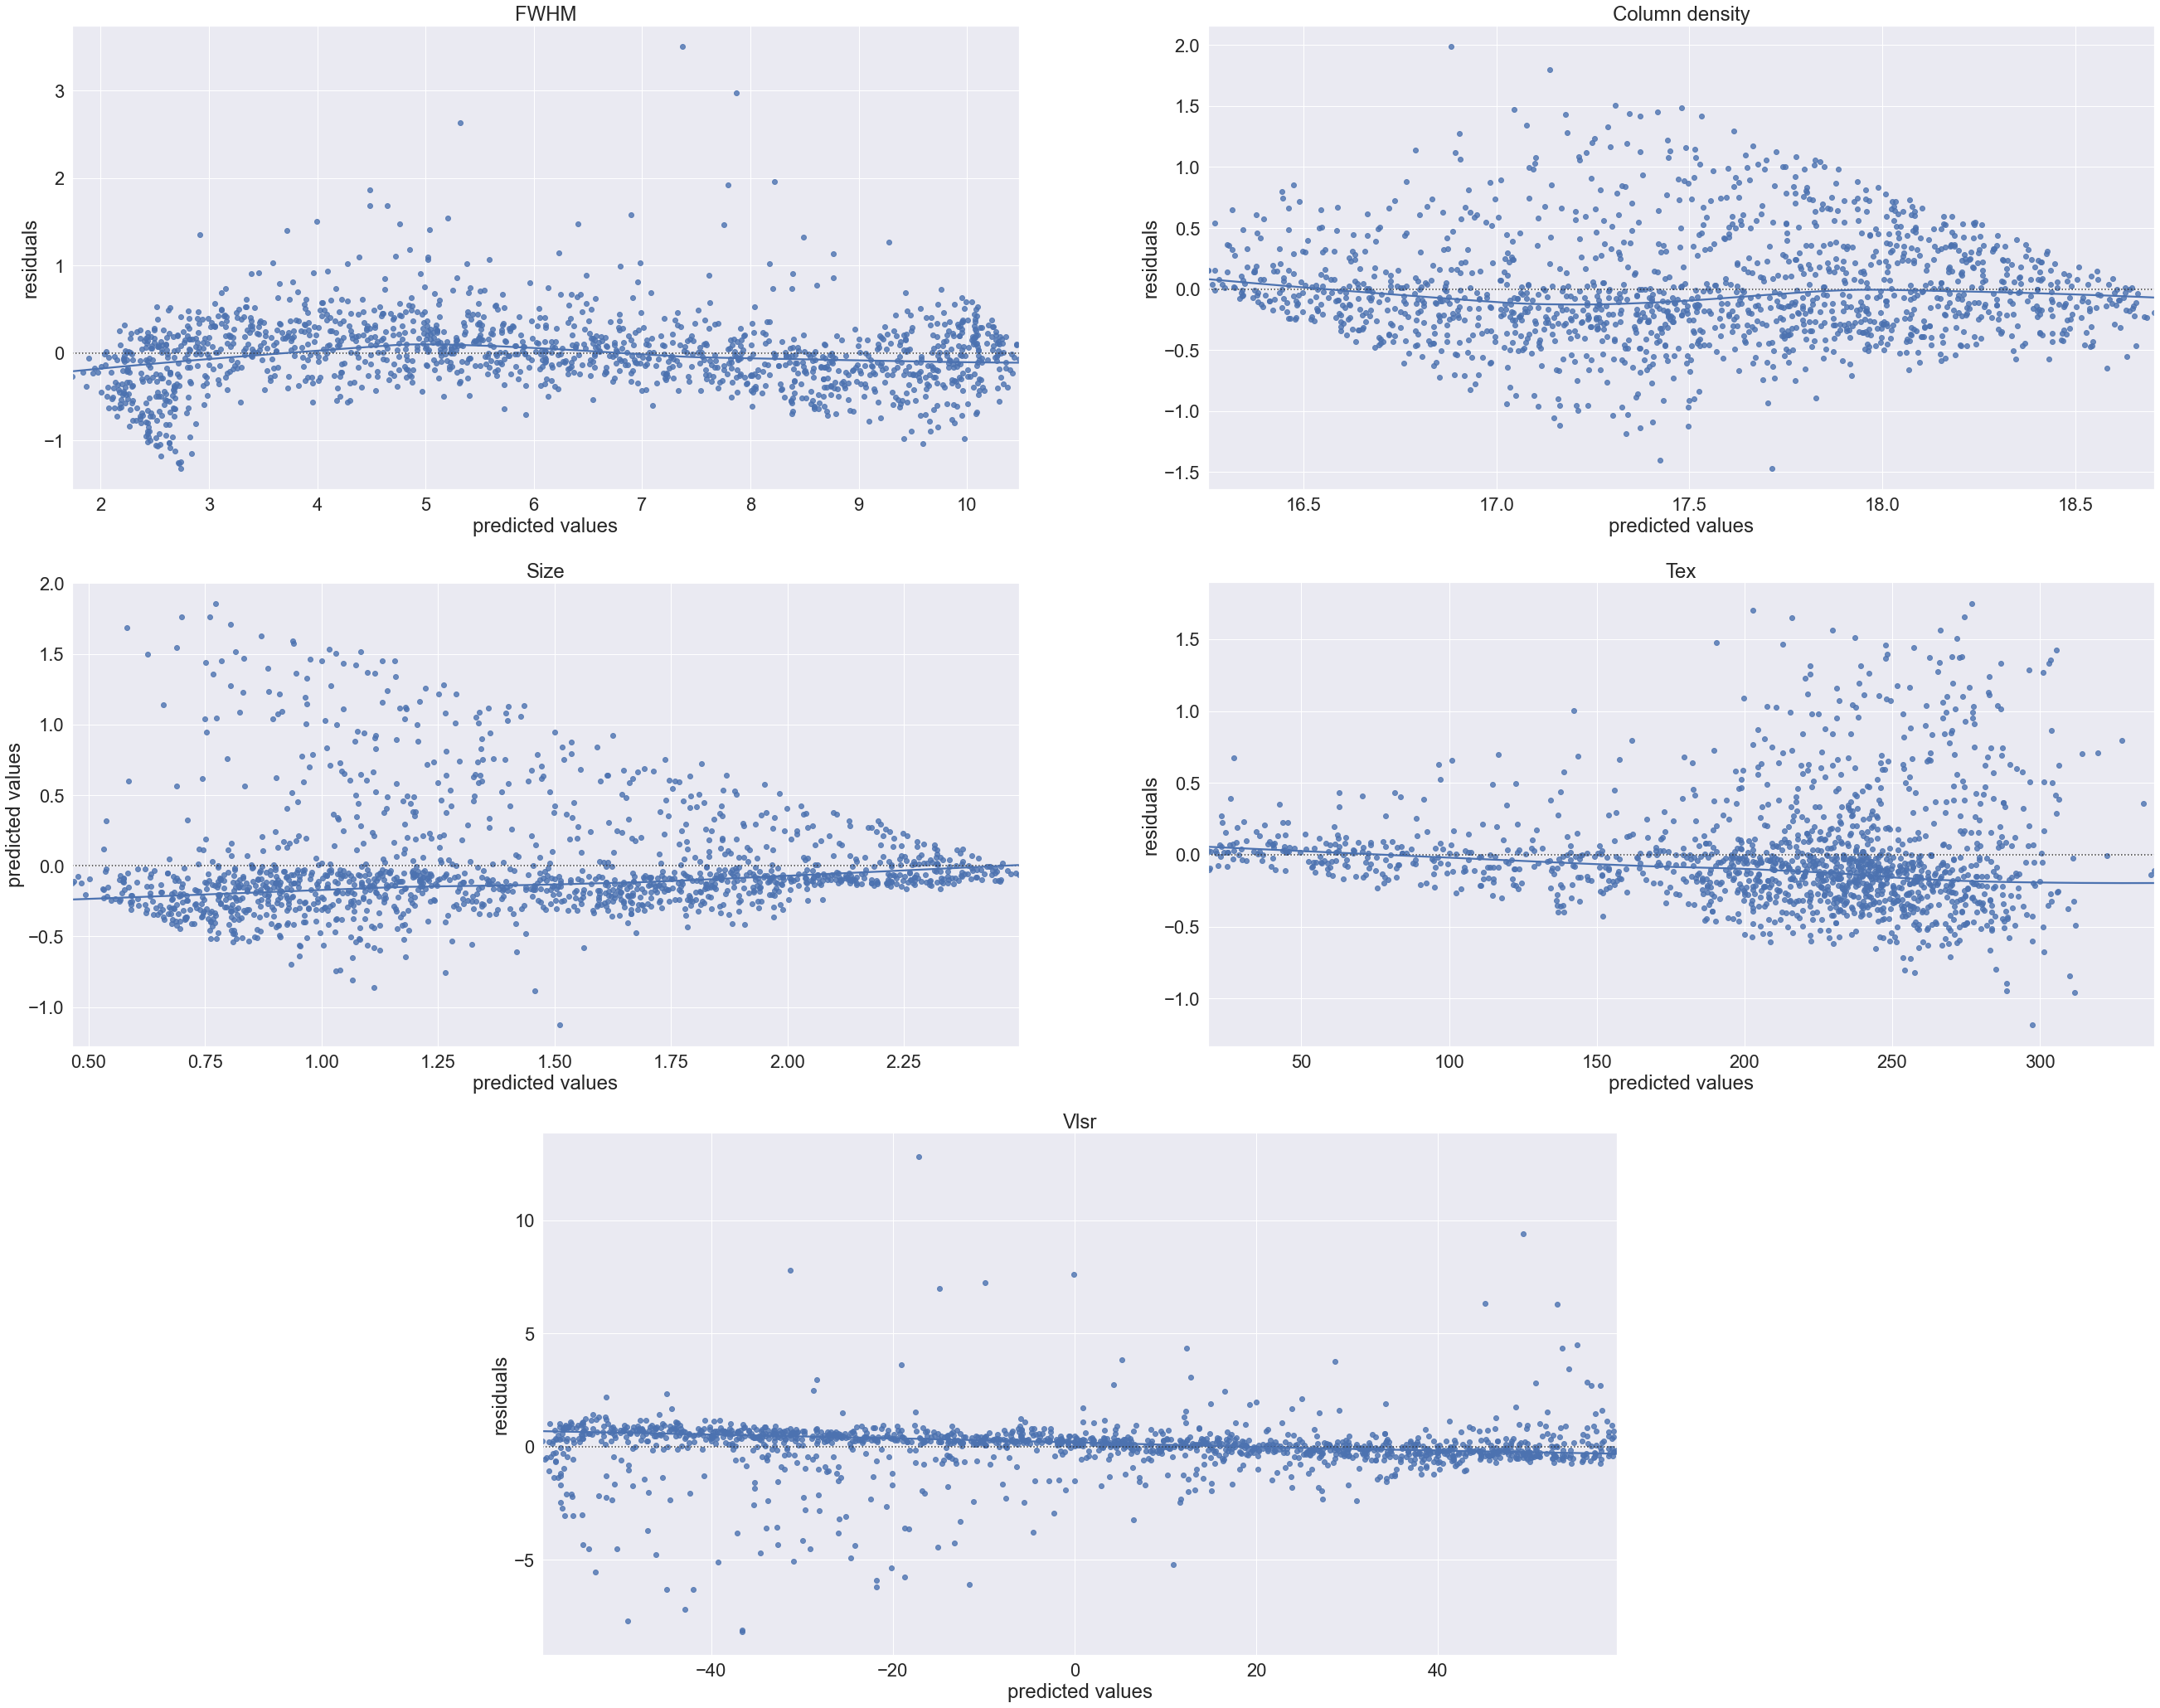

In [56]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

# plot the redisual distribution using seaborn
g1 = sns.residplot(x=y_multirf_pred[:,0], y=residuals_rf['fwhm'], lowess=True, ax=axes[0,0]) # fwhm
g2 = sns.residplot(x=y_multirf_pred[:,1], y=residuals_rf['ntot'], lowess=True, ax=axes[0,1]) # column density
g3 = sns.residplot(x=y_multirf_pred[:,2], y=residuals_rf['size'], lowess=True, ax=axes[1,0]) # size
g4 = sns.residplot(x=y_multirf_pred[:,3], y=residuals_rf['size'], lowess=True, ax=axes[1,1]) # tex
g5 = sns.residplot(x=y_multirf_pred[:,4], y=residuals_rf['vlsr'], lowess=True, ax=axes[2,0]) # vlsr

g1.set(title='FWHM', ylabel="residuals", xlabel="predicted values")
g2.set(title='Column density', ylabel="residuals", xlabel="predicted values")
g3.set(title='Size', ylabel="predicted values", xlabel="predicted values")
g4.set(title='Tex', ylabel="residuals", xlabel="predicted values")
g5.set(title='Vlsr', ylabel="residuals", xlabel="predicted values")

plt.savefig("data/5K_gen_files/residuals_RF_5K.png")
plt.show()

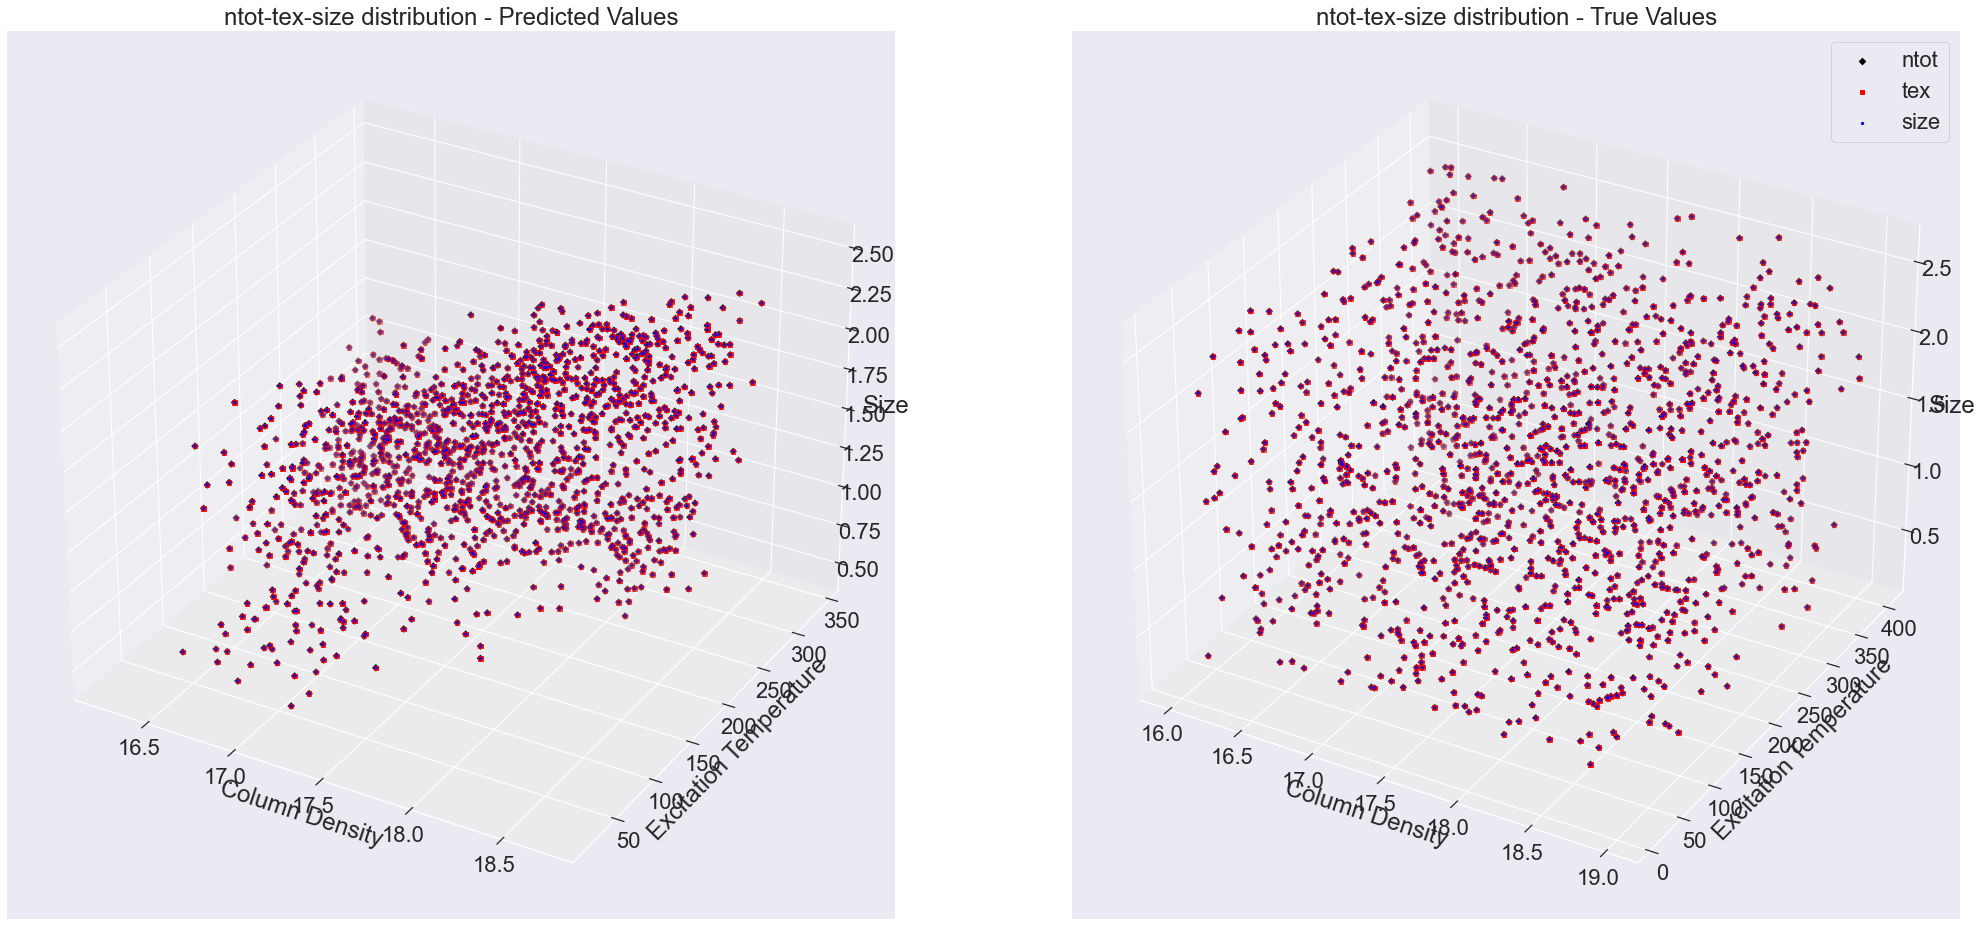

In [57]:
fig = plt.figure(figsize=(35, 25))
plt.setp(ax.get_xticklabels(), fontsize=14)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']

x2 = y_test['ntot']
y2 = y_test['tex']
z2 = y_test['size']


for i in range(len(markers)):
    x1 = pred_param_rf['ntot']
    y1 = pred_param_rf['tex']
    z1 = pred_param_rf['size']
    
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])
    ax2.scatter3D(x2, y2, z2, marker=markers[i], color=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Predicted Values')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')


ax2.set_title('ntot-tex-size distribution - True Values')
ax2.set_xlabel('Column Density')
ax2.set_ylabel('Excitation Temperature')
ax2.set_zlabel('Size')
plt.legend(loc="best")

plt.savefig("data/5K_gen_files/scatter3D_pred_true_5K_RF.png")
plt.show()

All the points are taking up the same position in a 3D space. Not sure if this is how its supposed to be. From my understanding, the Column density is dependent on Temperature, so they take the `x`, and `y` positions while size takes the `z` position.plt

## Hyperparameter Tuning for Random Forest

In [58]:
# multirf_model = MultiOutputRegressor(
#     RandomForestRegressor(
#         n_estimators=100,
#         max_depth=10,
#         min_samples_split=2,
#         min_samples_leaf=1,
#         min_weight_fraction_leaf=0.0,
#         criterion="squared_error",
#         bootstrap=True,
#         n_jobs=-1,
#         max_samples=None,
# ))

# multrf_hyperparameters = dict(
#     estimator__n_estimators=np.arange(100, 1000, 100),
#     estimator__max_depth=np.arange(10, 150, 10),
#     estimator__min_samples_split=np.arange(2, 10, 2),
#     estimator__min_samples_leaf=np.arange(1, 5, 1),
#     # estimator__min_weight_fraction_leaf=np.arange(0, 0.5, 0.1),
#     # estimator__criterion=["squared_error", "absolute_error"],
#     estimator__max_features=["auto", "sqrt", "log2"],
#     # estimator__max_samples=np.arange(0.5, 1, 0.1),
#     estimator__bootstrap=["True", "False"]
#     )

In [59]:
# random_search = RandomizedSearchCV(
#     estimator=multirf_model,
#     param_distributions=multrf_hyperparameters,
#     n_iter=100,
#     cv=5,
#     verbose=2,
#     error_score="raise",
#     n_jobs=-1,
#     random_state=42,
#     return_train_score=True
# )

In [60]:
# # best parameters from tuned model
# regr_tuned_multirf = MultiOutputRegressor(
#     estimator=RandomForestRegressor(
#        n_estimators=800, 
#        min_samples_split=2,
#        min_samples_leaf=1,
#        max_features='auto', 
#        max_depth=130,
#        bootstrap=True,
#        verbose=5
#     )
# )

In [61]:
# hyper_rf_tuned_model = regr_tuned_multirf.fit(X_train, y_train)

In [62]:
# y_multirf_tuned_rf = hyper_rf_tuned_model.predict(X_test)

In [63]:
# print("Best hyperparameters: ", hyper_rf_tuned_model.best_params_)
# print("Best score: ", hyper_rf_tuned_model.best_score_)

Best hyperparameters:  {'estimator__n_estimators': 800, 'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 1, 'estimator__max_features': 'auto', 'estimator__max_depth': 130, 'estimator__bootstrap': 'True'}
Best score:  0.6780101270617723

In [64]:
# tuned_rf_model = hyper_rf_tuned_model.best_estimator_
# y_multrf_tuned_tf = tuned_rf_model.predict(X_test)

In [65]:
# # # TODO: interpret the model evaluation metrics
# eval = RegressionMetrics()
# for metric in _metrics:
#     print(metric, ":", eval.get_metric(metric, y_test, y_multirf_tuned_rf))

### True vs Predicted Values - RF Tuned Model

In [66]:
# fig, axes = plt.subplots(3, 2, figsize=(45,35))
# plt.setp(ax.get_xticklabels(), fontsize=14)
# sns.set_theme(font_scale=2) 
# axes[2,1].set_visible(False)
# axes[2,0].set_position([0.30, 0.1,0.40,0.25])

# g1 = sns.regplot(x=y_test.iloc[:,0], y=y_multirf_tuned_rf[:,0], color='orange', ax=axes[0,0]) # fwhm
# g2 = sns.regplot(x=y_test.iloc[:,1], y=y_multirf_tuned_rf[:,1], color='orange', ax=axes[0,1]) # column density
# g3 = sns.regplot(x=y_test.iloc[:,2], y=y_multirf_tuned_rf[:,2], color='orange', ax=axes[1,0]) # size
# g4 = sns.regplot(x=y_test.iloc[:,3], y=y_multirf_tuned_rf[:,3], color='orange', ax=axes[1,1]) # tex
# g5 = sns.regplot(x=y_test.iloc[:,4], y=y_multirf_tuned_rf[:,4], color='orange', ax=axes[2,0]) # vlsr

# g1.set(title='FWHM', ylabel="predicted values", xlabel="true values")
# g2.set(title='Column density', ylabel="predicted values", xlabel="true values", xscale='log', yscale='log')
# g3.set(title='Size', ylabel="predicted values", xlabel="true values")
# g4.set(title='Tex', ylabel="predicted values", xlabel="true values")
# g5.set(title='Vlsr', ylabel="predicted values", xlabel="true values")

# plt.savefig("data/5K_gen_files/pred_true_5K_tuned_RF.png")
# plt.show()

### Residuals - RF Tuned Model

In [67]:
# residuals_tuned_rf = (y_test - y_multirf_tuned_rf)
# residuals_tuned_rf

In [68]:
# fig, axes = plt.subplots(3, 2, figsize=(45,35))
# plt.setp(ax.get_xticklabels(), fontsize=14)
# sns.set_theme(font_scale=2) 
# axes[2,1].set_visible(False)
# axes[2,0].set_position([0.30, 0.1,0.40,0.25])

# # plot the redisual distribution using seaborn
# g1 = sns.residplot(x=y_multirf_tuned_rf[:,0], y=residuals_tuned_rf['fwhm'], lowess=True, ax=axes[0,0], color='orange') # fwhm
# g2 = sns.residplot(x=y_multirf_tuned_rf[:,1], y=residuals_tuned_rf['ntot'], lowess=True, ax=axes[0,1], color='orange') # column density
# g3 = sns.residplot(x=y_multirf_tuned_rf[:,2], y=residuals_tuned_rf['size'], lowess=True, ax=axes[1,0], color='orange') # size
# g4 = sns.residplot(x=y_multirf_tuned_rf[:,3], y=residuals_tuned_rf['size'], lowess=True, ax=axes[1,1], color='orange') # tex
# g5 = sns.residplot(x=y_multirf_tuned_rf[:,4], y=residuals_tuned_rf['vlsr'], lowess=True, ax=axes[2,0], color='orange') # vlsr
# g1.set(title='FWHM', ylabel="residuals", xlabel="predicted values")
# g2.set(title='Column density', ylabel="residuals", xlabel="predicted values")
# g3.set(title='Size', ylabel="predicted values", xlabel="predicted values")
# g4.set(title='Tex', ylabel="residuals", xlabel="predicted values")
# g5.set(title='Vlsr', ylabel="residuals", xlabel="predicted values")

# plt.savefig("data/5K_gen_files/residuals_tuned_RF_5K.png")
# plt.show()

## 2. XGBoost Regressor

In [69]:
multixgb_model = MultiOutputRegressor(
    xgb.XGBRegressor(
        n_estimators=100,
        max_depth=10,
        max_leaves=10,
        max_bin=10,
        learning_rate=0.1,
        n_jobs=-1,
        gamma=0,
        min_child_weight=1.0,
        max_delta_step=0,
        importance_type="gain",
        eval_metric=metrics.mean_squared_error
    )
)

multixgb_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            enable_categorical=False,
                                            eval_metric=<function mean_squared_error at 0x7fd666c56b80>,
                                            gamma=0, gpu_id=None,
                                            importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=10,
                                            max_delta_step=0, max_depth=10,
                                            max_leaves=10, min_child_weight=1.0,
                                            missing=nan,
                                            monoton

In [70]:
y_multixgb_pred = multixgb_model.predict(X_test)

In [71]:
for metric in _metrics:
    print(metric, ":", metrics_multirf.get_metric(metric, y_test, y_multixgb_pred))

mae : 9.332063424900438
mse : 685.1072240393893
rmse : 26.17455298642919
mape : fwhm     7.863548
ntot     1.950183
size    25.431477
tex     29.255912
vlsr     9.346436
dtype: float64
r2 : 0.8219881951537152
msle : 26.17455298642919


### save the predicted parameters to a csv file

In [72]:
param_df_xgb = pd.DataFrame(y_multixgb_pred, columns=['fwhm_pred_xgb', 'ntot_pred_xgb', 'size_pred_xgb', 'tex_pred_xgb', 'vlsr_pred_xgb'])
param_df_xgb['ntot_pred_xgb'] = np.array(10**param_df_xgb['ntot_pred_xgb'])
param_df_xgb.to_csv('data/5K_gen_files/predicted_parameters_xgb.csv')

In [73]:
param_df_xgb.head()

fwhm_pred_xgb  ntot_pred_xgb  size_pred_xgb  tex_pred_xgb  vlsr_pred_xgb
0       4.023579   4.564982e+16       0.928004    228.888382      59.162666
1       5.188456   3.836614e+16       0.703717    208.414505     -43.660168
2       3.505985   5.889581e+17       2.144363    183.762085      -8.135884
3       8.926311   1.286340e+17       1.354705    305.774841       4.800201
4       2.774076   9.168160e+17       2.123909    225.373428      41.356651

### Predicted vs True values - XGB Regressor

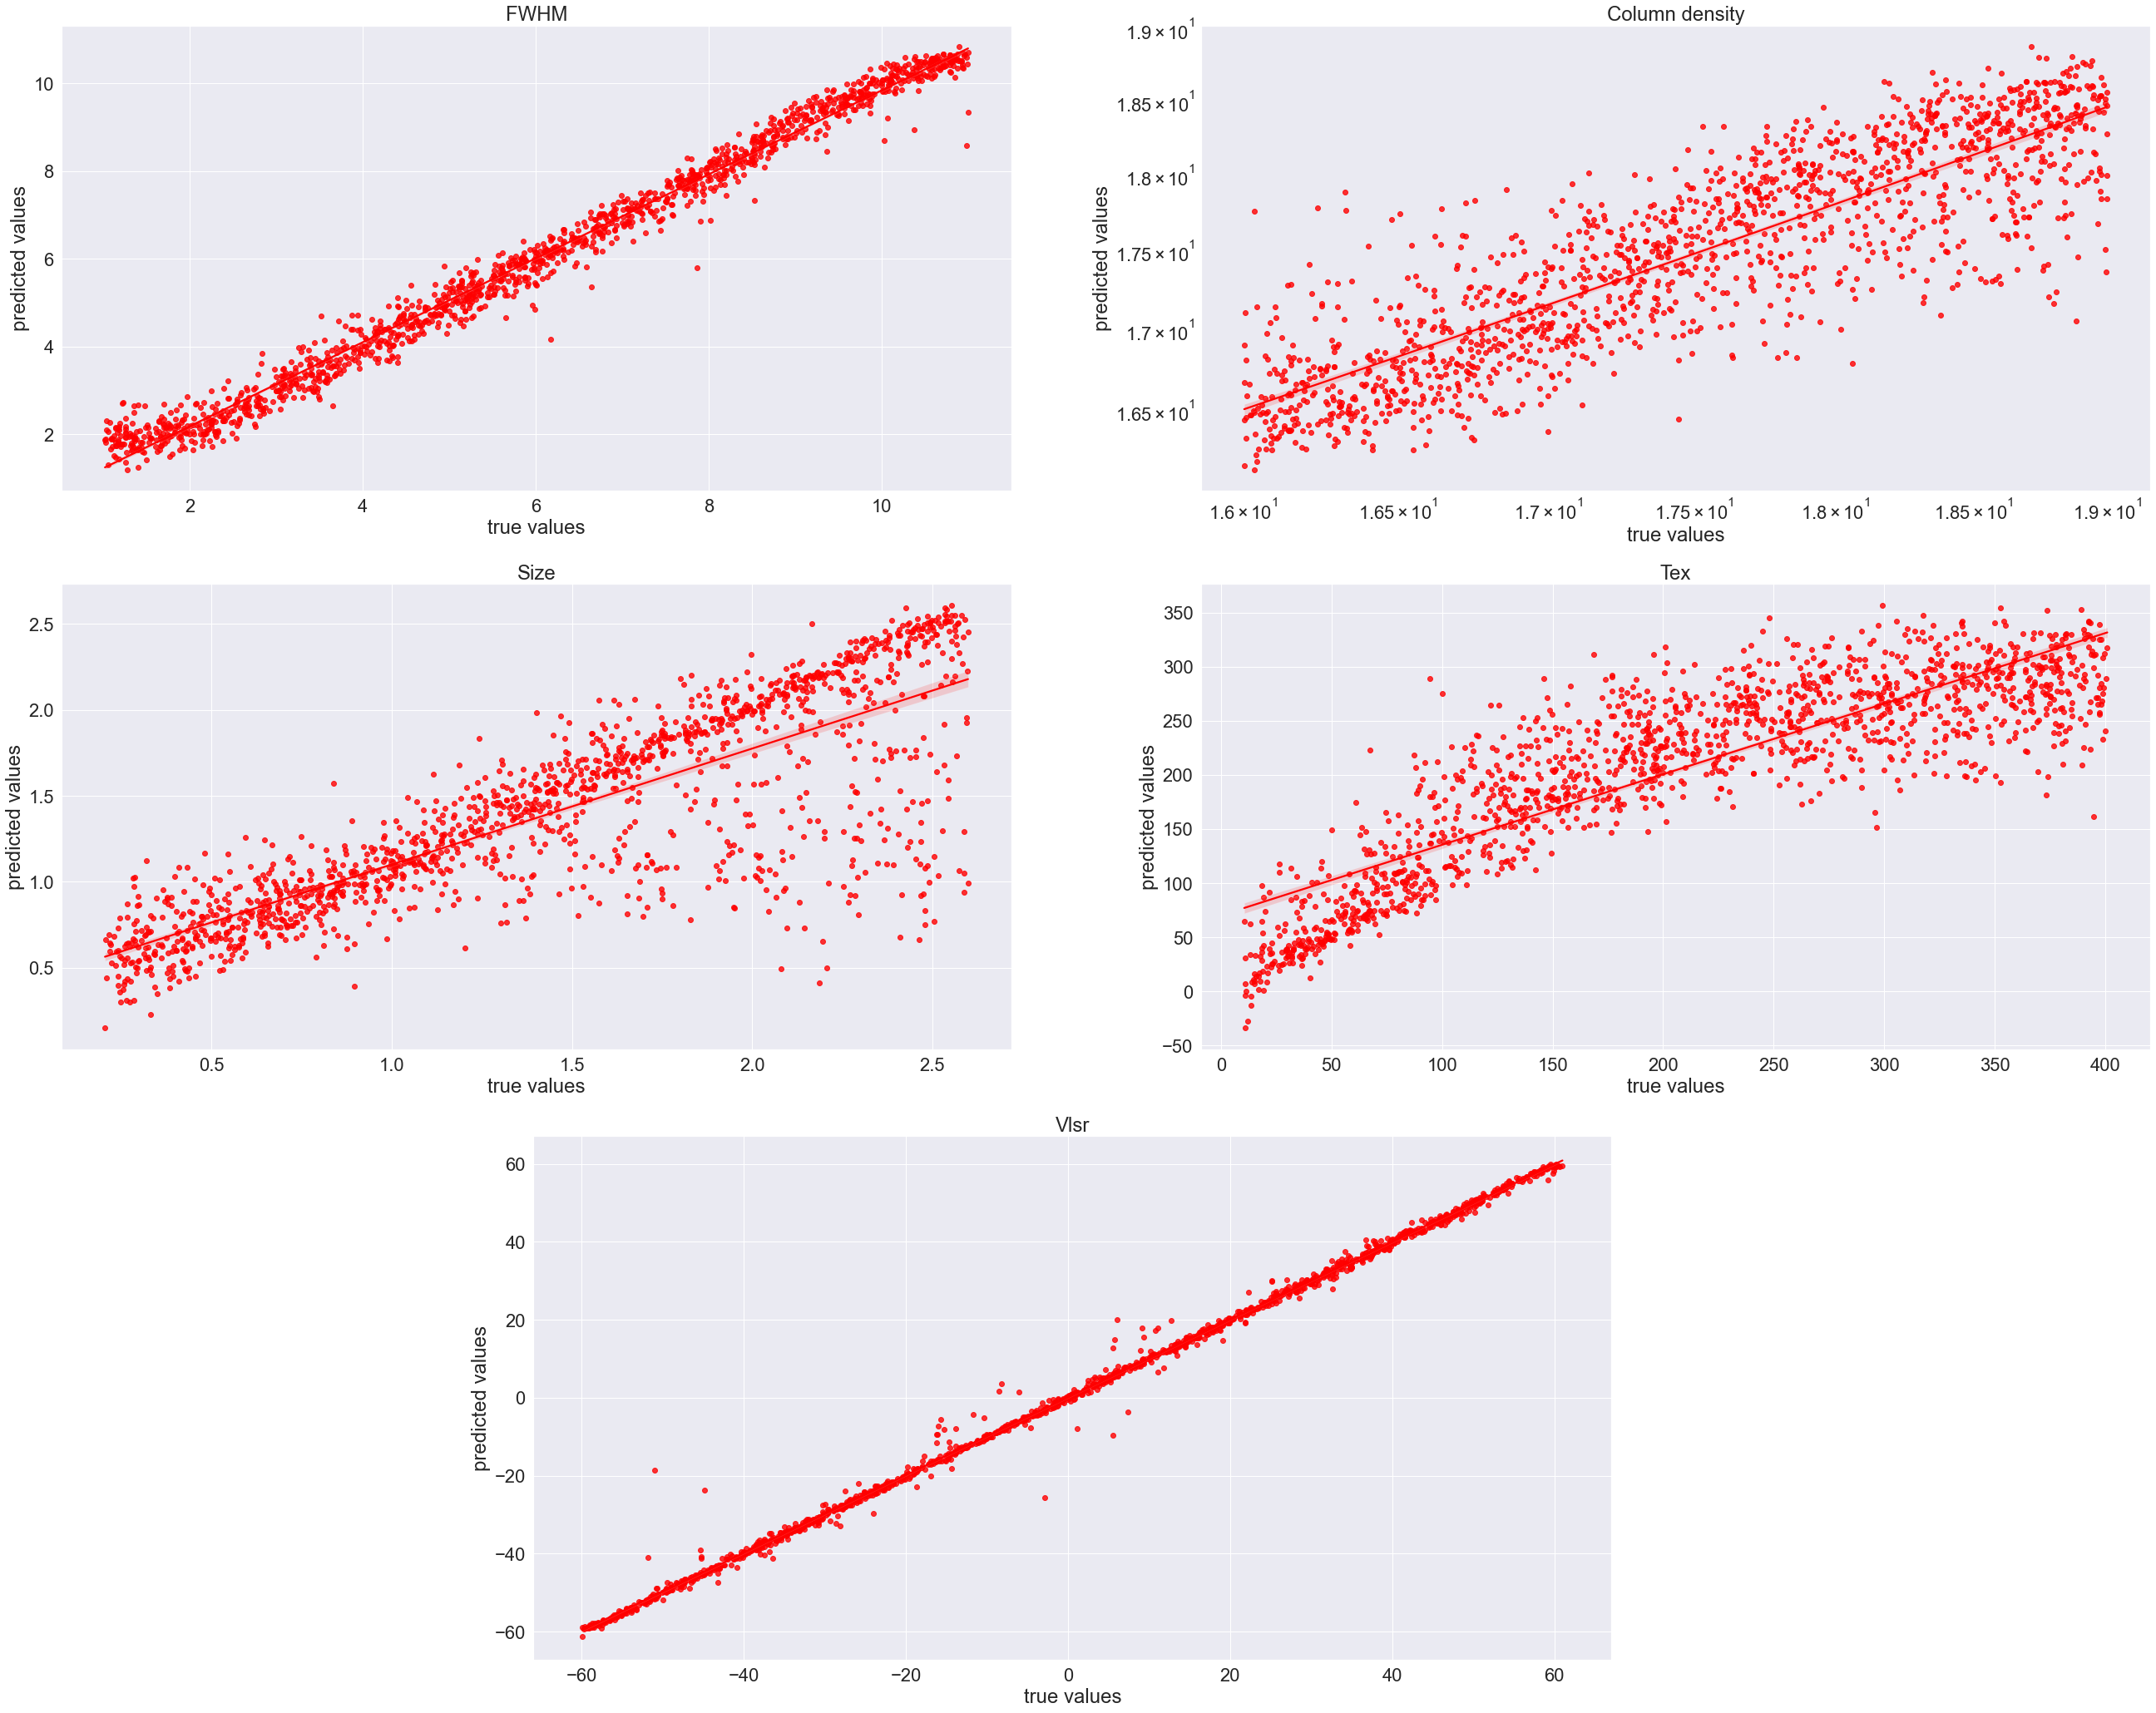

In [74]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

g1 = sns.regplot(x=y_test.iloc[:, 0], y=y_multixgb_pred[:,0],color='red', ax=axes[0,0]) # fwhm
g2 = sns.regplot(x=y_test.iloc[:,1], y=y_multixgb_pred[:,1], color='red', ax=axes[0,1]) # column density
g3 = sns.regplot(x=y_test.iloc[:,2], y=y_multixgb_pred[:,2], color='red', ax=axes[1,0]) # size
g4 = sns.regplot(x=y_test.iloc[:,3], y=y_multixgb_pred[:,3], color='red', ax=axes[1,1]) # tex
g5 = sns.regplot(x=y_test.iloc[:,4], y=y_multixgb_pred[:,4], color='red', ax=axes[2,0]) # vlsr
g1.set(title='FWHM', ylabel="predicted values", xlabel="true values")
g2.set(title='Column density', ylabel="predicted values", xlabel="true values", yscale="log", xscale="log")
g3.set(title='Size', ylabel="predicted values", xlabel="true values")
g4.set(title='Tex', ylabel="predicted values", xlabel="true values")
g5.set(title='Vlsr', ylabel="predicted values", xlabel="true values")

plt.savefig("data/5K_gen_files/pred_true_5K_XGB.png")
plt.show()

### 3D plots - Columnn density, Excitation temperature and Size - XGB Regressor

In [75]:
pred_param_xgb = pd.DataFrame(y_multixgb_pred, columns=['fwhm', 'ntot', 'size', 'tex', 'vlsr'])
pred_param_xgb.head()

fwhm       ntot      size         tex       vlsr
0  4.023579  16.659439  0.928004  228.888382  59.162666
1  5.188456  16.583948  0.703717  208.414505 -43.660168
2  3.505985  17.770084  2.144363  183.762085  -8.135884
3  8.926311  17.109356  1.354705  305.774841   4.800201
4  2.774076  17.962282  2.123909  225.373428  41.356651

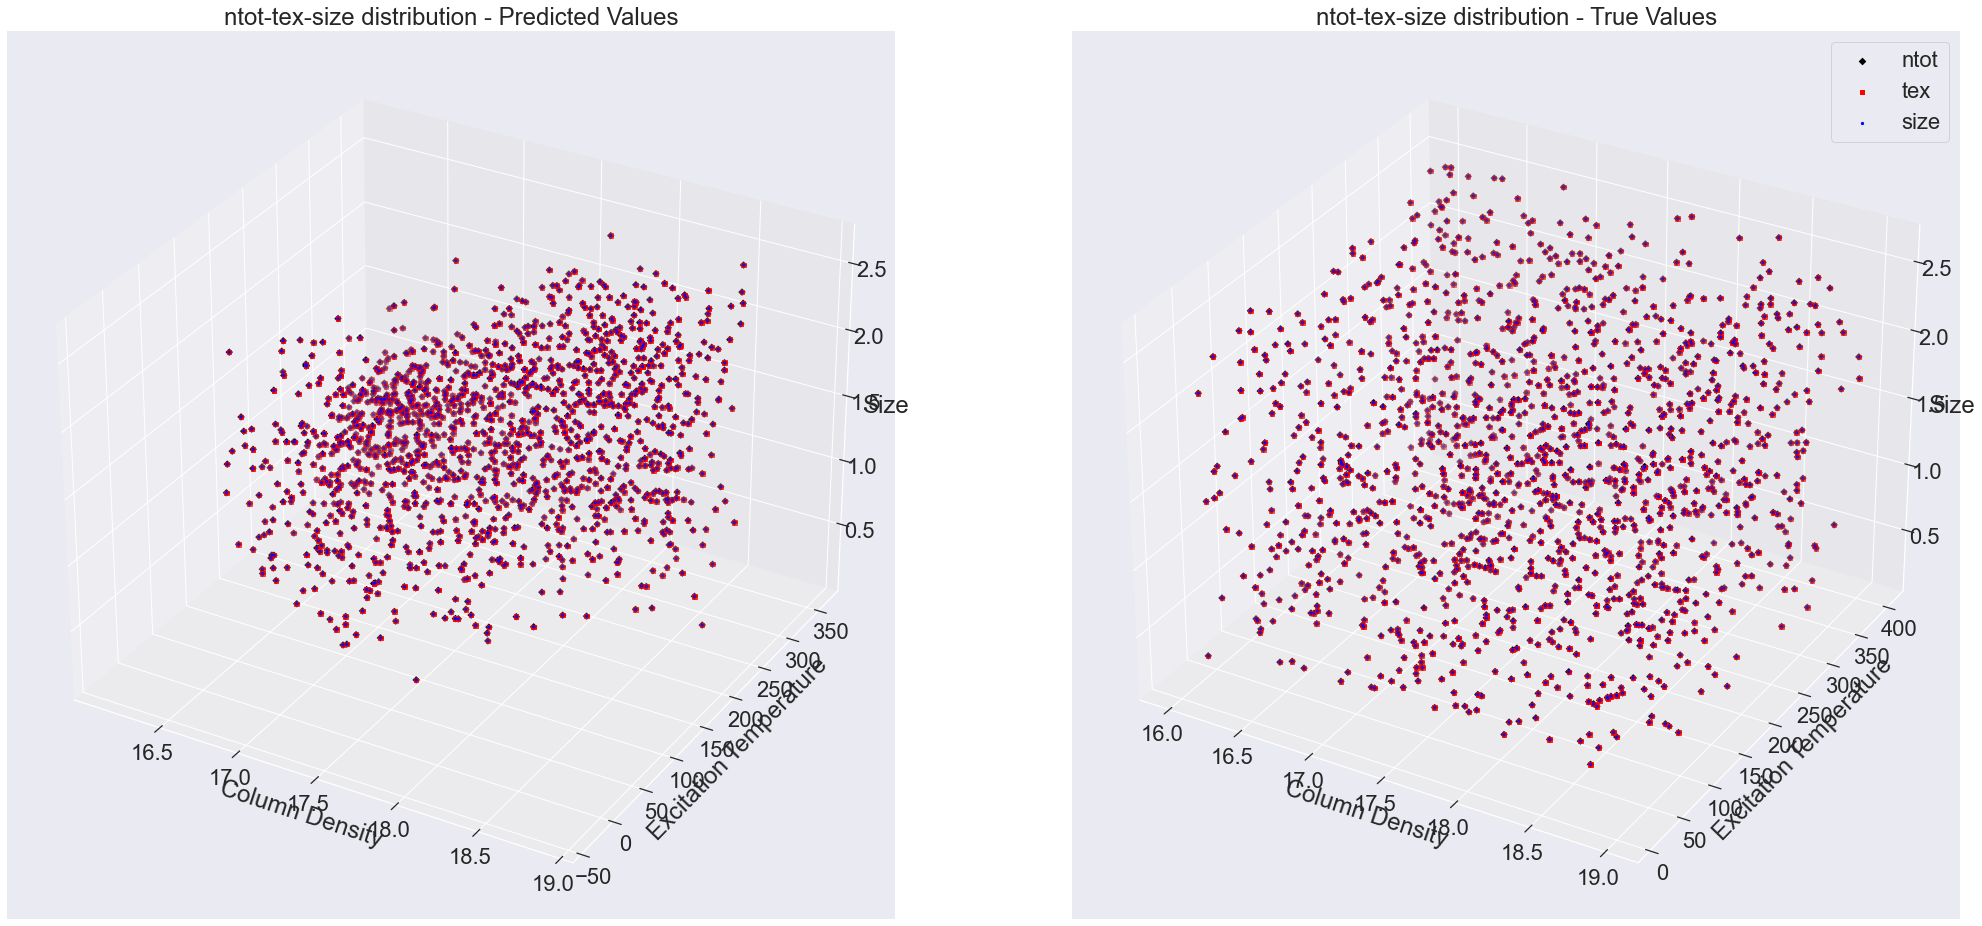

In [76]:
fig = plt.figure(figsize=(35, 25))
plt.setp(ax.get_xticklabels(), fontsize=14)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')


markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']


x1 = pred_param_xgb['ntot']
y1 = pred_param_xgb['tex']
z1 = pred_param_xgb['size']
    
x2 = y_test['ntot']
y2 = y_test['tex']
z2 = y_test['size']


for i in range(len(markers)):
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])
    ax2.scatter3D(x2, y2, z2, marker=markers[i], color=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Predicted Values')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')


ax2.set_title('ntot-tex-size distribution - True Values')
ax2.set_xlabel('Column Density', )
ax2.set_ylabel('Excitation Temperature')
ax2.set_zlabel('Size')
plt.legend(loc="best")

plt.savefig("data/5K_gen_files/scatter3D_pred_true_5K_XGB.png")
plt.show()

### Residuals 3D plot - XGB Regressor

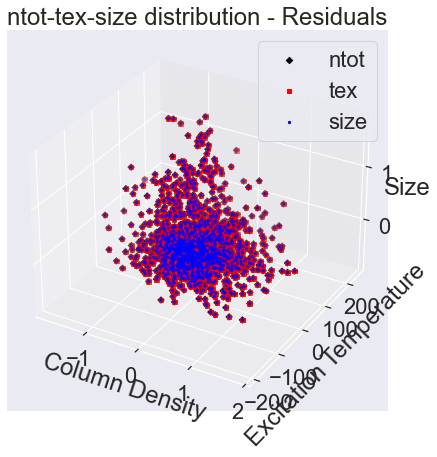

In [77]:
fig = plt.figure(figsize=(15, 7))
plt.setp(ax.get_xticklabels(), fontsize=14)
ax1 = fig.add_subplot(121, projection='3d')

markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']

residuals_xgb = (y_test - y_multixgb_pred)
# residuals
x1 = residuals_xgb['ntot']
y1 = residuals_xgb['tex']
z1 = residuals_xgb['size']

for i in range(len(markers)):
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Residuals')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')
plt.legend(loc="best")
plt.show()

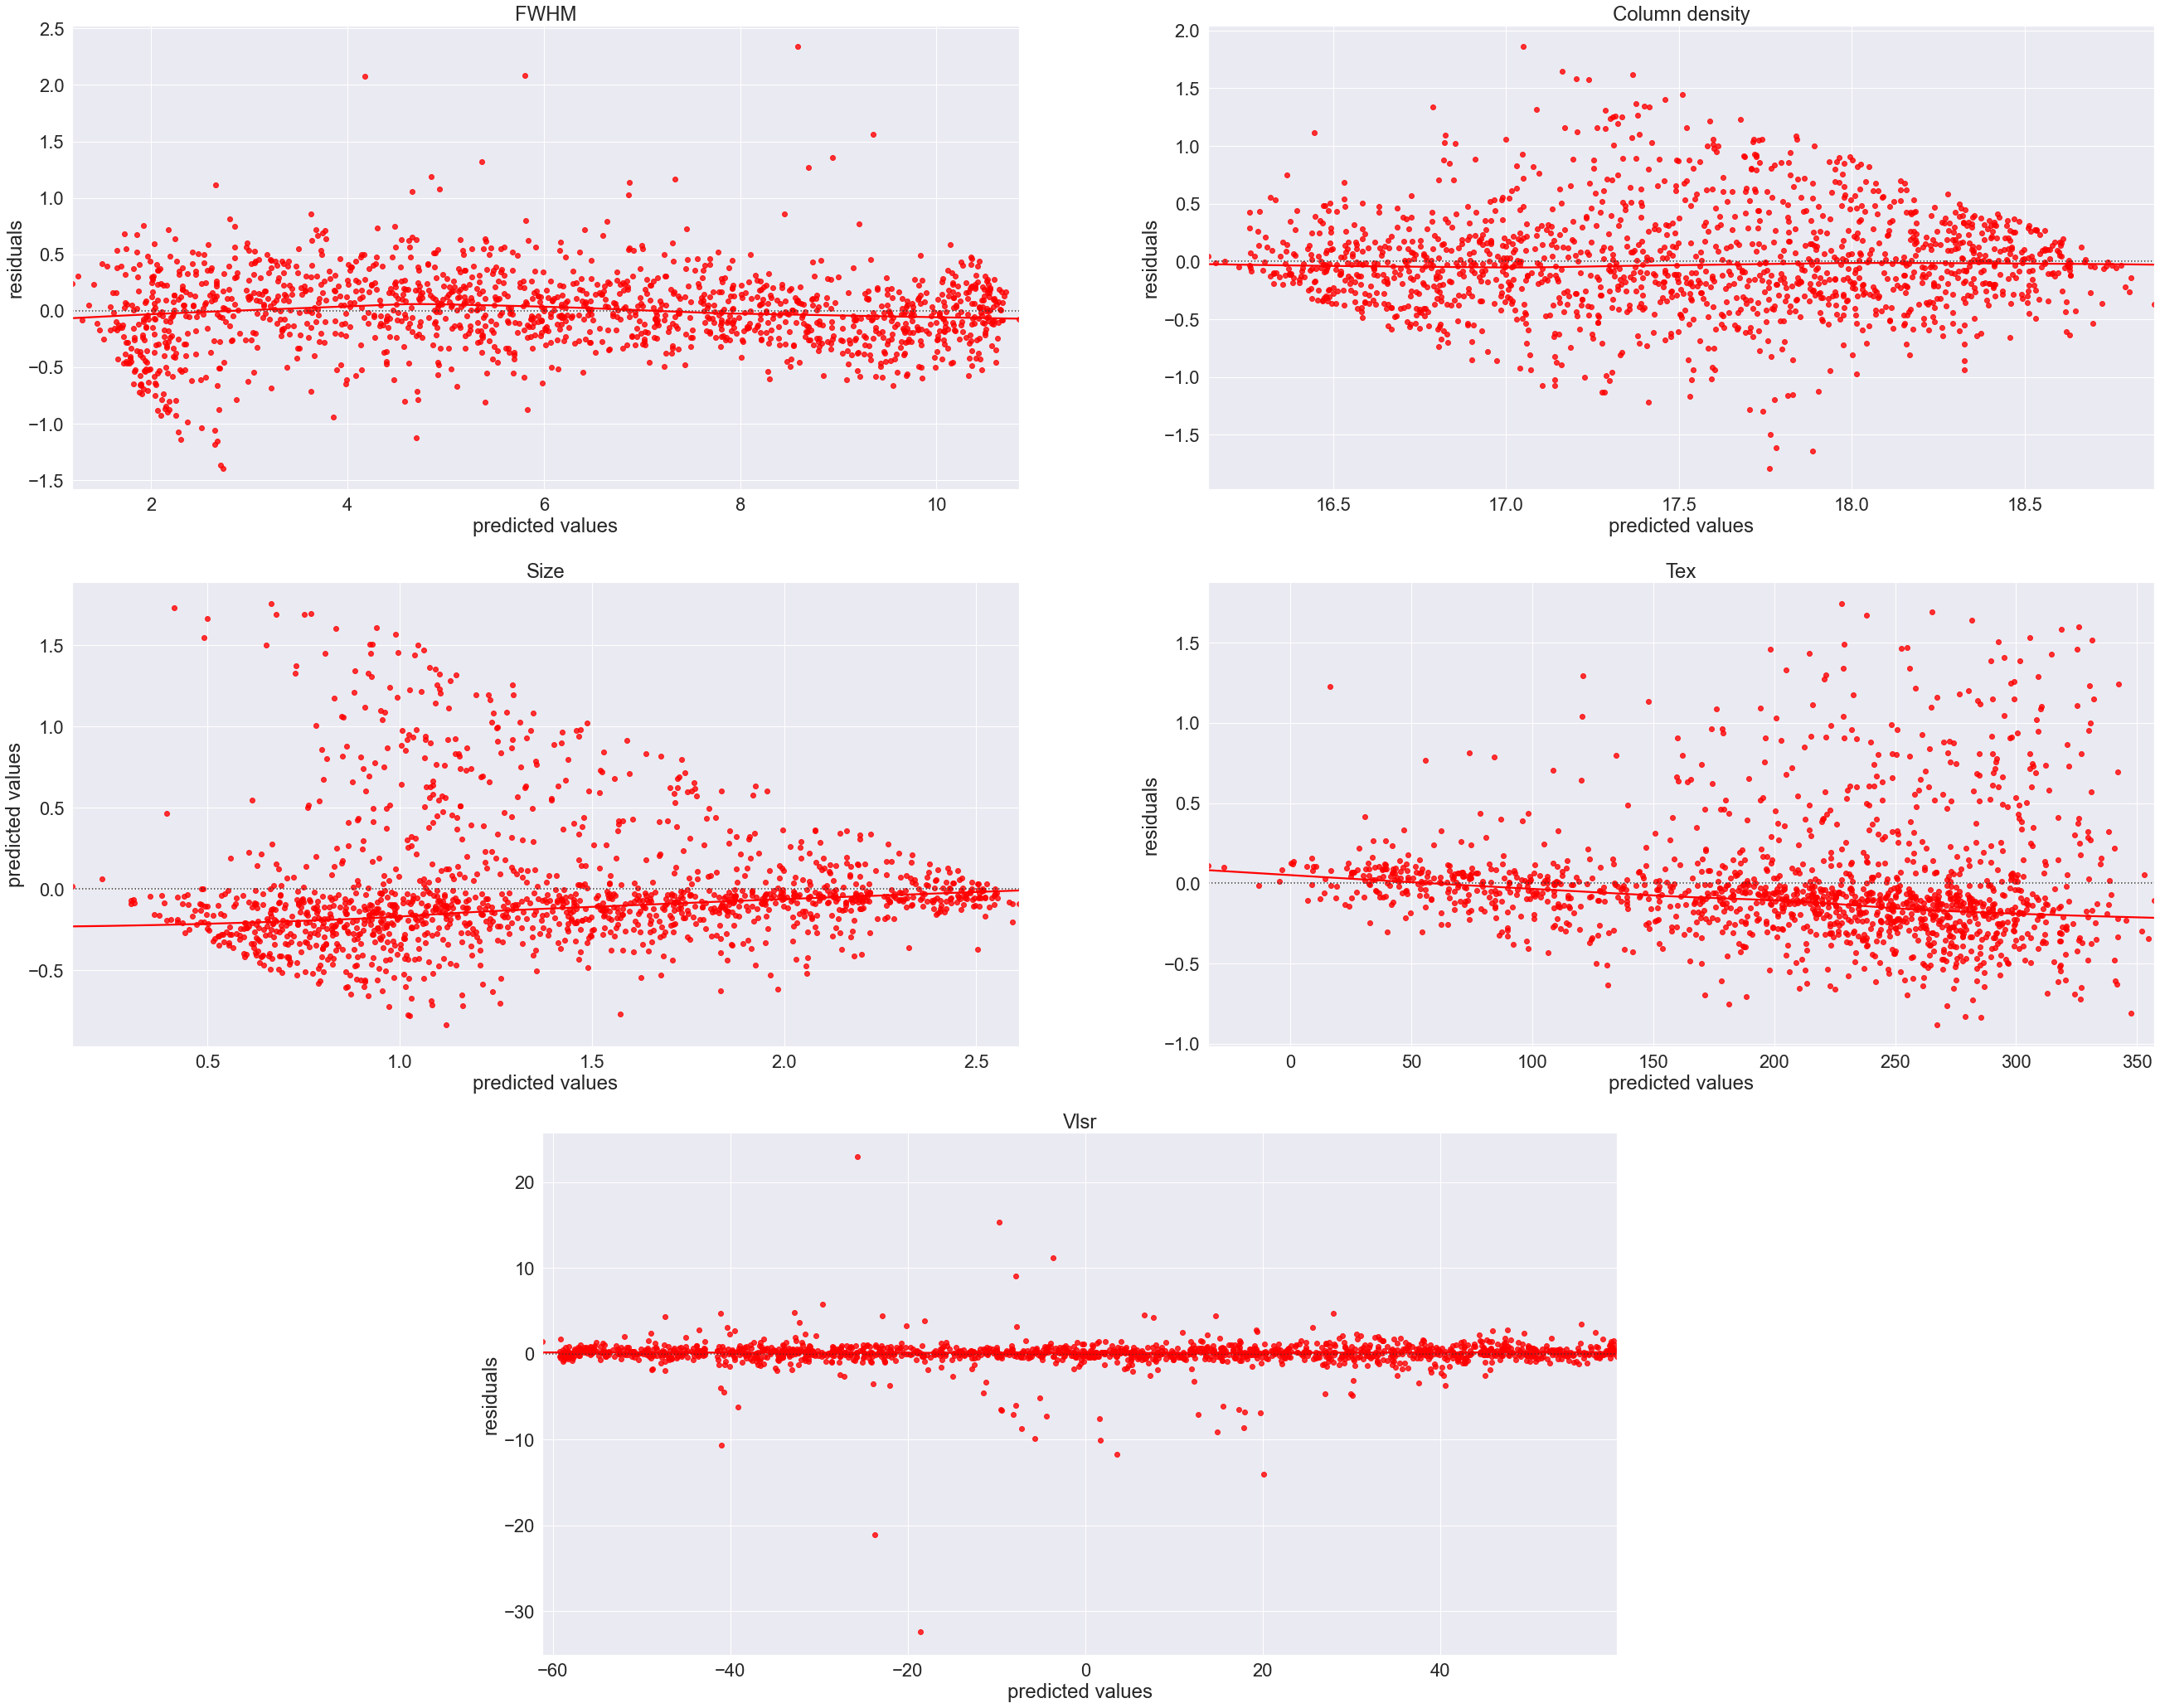

In [78]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

# plot the redisual distribution using seaborn
g1 = sns.residplot(x=y_multixgb_pred[:,0], y=residuals_xgb['fwhm'], lowess=True, ax=axes[0,0], color='red') # fwhm
g2 = sns.residplot(x=y_multixgb_pred[:,1], y=residuals_xgb['ntot'], lowess=True, ax=axes[0,1], color='red') # column density
g3 = sns.residplot(x=y_multixgb_pred[:,2], y=residuals_xgb['size'], lowess=True, ax=axes[1,0], color='red') # size
g4 = sns.residplot(x=y_multixgb_pred[:,3], y=residuals_xgb['size'], lowess=True, ax=axes[1,1], color='red') # tex
g5 = sns.residplot(x=y_multixgb_pred[:,4], y=residuals_xgb['vlsr'], lowess=True, ax=axes[2,0], color='red') # vlsr

g1.set(title='FWHM', ylabel="residuals", xlabel="predicted values")
g2.set(title='Column density', ylabel="residuals", xlabel="predicted values")
g3.set(title='Size', ylabel="predicted values", xlabel="predicted values")
g4.set(title='Tex', ylabel="residuals", xlabel="predicted values")
g5.set(title='Vlsr', ylabel="residuals", xlabel="predicted values")

plt.savefig("data/5K_gen_files/residuals_XGB_5K.png")
plt.show()